# Experiment 1: GPT-2 on wikitext but scaled down


In [ ]:
# Install required packages (run once)
!pip install -q transformers datasets accelerate evaluate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Imports
import math, time, os, random
from collections import Counter, defaultdict
from functools import partial
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Config (tune these for Colab convenience)
block_size = 128          # sequence length per example
train_examples = 20000    # number of blocks to use (small proxy). Increase to scale up.
batch_size = 8            # small batch for Colab GPU
groups = 10               # number of frequency groups (≈10%)

# Load tokenizer & dataset
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# ensure eos/pad tokens
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

ds = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train')

# Concatenate texts and tokenize into a single long stream of tokens
def all_tokens(example):
    return tokenizer(example['text'])['input_ids']

# convert to token stream (this can be memory heavy for whole dataset; using subset)
texts = ds['text'][:5000]  # use first 5000 raw docs for proxy; increase for larger runs
tok_stream = []
for t in texts:
    if t is None or t.strip()=='':
        continue
    tok_stream.extend(tokenizer.encode(t))

# turn into blocks of block_size
input_ids = []
for i in range(0, len(tok_stream) - block_size, block_size):
    block = tok_stream[i:i+block_size]
    input_ids.append(block)
input_ids = input_ids[:train_examples]  # limit number of training examples for Colab
print("Prepared blocks:", len(input_ids))

# compute token frequency across all tokens used
flat = [tid for block in input_ids for tid in block]
freq = Counter(flat)
vocab_size = tokenizer.vocab_size
print("Vocab size (tokenizer):", vocab_size)
print("Unique tokens observed in sample:", len(freq))

# create groups of tokens by frequency such that each group covers ~10% of total tokens
# sort tokens by frequency descending
token_freq_pairs = sorted(freq.items(), key=lambda x: x[1], reverse=True)
total_tokens = sum(freq.values())
group_target = total_tokens / groups

groups_list = []
cur_group = set()
cur_sum = 0
for tok, c in token_freq_pairs:
    cur_group.add(tok)
    cur_sum += c
    if cur_sum >= group_target:
        groups_list.append(cur_group)
        cur_group = set()
        cur_sum = 0
# append remaining
if cur_group:
    groups_list.append(cur_group)
# if not enough groups due to few unique tokens, pad
while len(groups_list) < groups:
    groups_list.append(set())

print("Number of groups:", len(groups_list))
# create token->group map
tok2group = {}
for gi, s in enumerate(groups_list):
    for tok in s:
        tok2group[tok] = gi
# tokens not observed -> assign to last group
for t in range(vocab_size):
    if t not in tok2group:
        tok2group[t] = groups-1

# helper to compute per-group loss from token-level losses
def accumulate_group_losses(token_ids, token_losses):
    # token_ids: (B, L) list or numpy; token_losses: same shape
    group_losses = np.zeros(groups)
    group_counts = np.zeros(groups)
    for tid_row, loss_row in zip(token_ids, token_losses):
        for tid, ls in zip(tid_row, loss_row):
            g = tok2group.get(int(tid), groups-1)
            group_losses[g] += float(ls)
            group_counts[g] += 1
    # avoid div by zero
    group_avg = group_losses / np.maximum(group_counts, 1)
    return group_avg, group_counts


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Prepared blocks: 2464
Vocab size (tokenizer): 50257
Unique tokens observed in sample: 21088
Number of groups: 10


In [ ]:
class BlockDataset(Dataset):
    def __init__(self, blocks):
        self.blocks = blocks
    def __len__(self):
        return len(self.blocks)
    def __getitem__(self, idx):
        ids = torch.tensor(self.blocks[idx], dtype=torch.long)
        return ids

train_dataset = BlockDataset(input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# small eval set (a held-out slice)
eval_blocks = input_ids[-1000:]
eval_dataset = BlockDataset(eval_blocks)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# training step function
def run_experiment(optimizer_name='adam', lr=1e-4, epochs=1, log_steps=200):
    torch.manual_seed(42)
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.resize_token_embeddings(len(tokenizer))  # in case we added pad token
    model.to(device)
    model.train()
    # optimizer choice
    if optimizer_name.lower() == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError(optimizer_name)
    total_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    global_step = 0

    # logs
    overall_losses = []
    group_losses_history = []  # list of arrays per log point
    steps_history = []

    # training
    for ep in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)  # shape (B, L)
            inputs = batch
            labels = batch.clone()
            outputs = model(input_ids=inputs, labels=labels)
            # outputs.loss is averaged over tokens in batch; we want per-token losses
            # compute per-token loss manually from logits
            logits = outputs.logits  # B x L x V
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            # flatten
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            B, Lm = shift_labels.shape
            loss_flat = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            per_token_loss = loss_flat.view(B, Lm).detach().cpu().numpy()
            # backprop using the averaged loss
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            # optional grad clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            global_step += 1

            # periodic eval on a small held-out set to compute group losses
            if global_step % log_steps == 0 or global_step == 1:
                model.eval()
                # compute overall loss on small eval dataset and group losses
                all_token_ids = []
                all_token_losses = []
                with torch.no_grad():
                    eval_loss_accum = 0.0
                    eval_tokens = 0
                    for ebatch in eval_loader:
                        ebatch = ebatch.to(device)
                        labels_e = ebatch.clone()
                        out = model(input_ids=ebatch, labels=labels_e)
                        logits_e = out.logits
                        shift_logits_e = logits_e[:, :-1, :].contiguous()
                        shift_labels_e = labels_e[:, 1:].contiguous()
                        loss_flat_e = loss_fct(shift_logits_e.view(-1, shift_logits_e.size(-1)), shift_labels_e.view(-1))
                        per_token_loss_e = loss_flat_e.view(shift_labels_e.size(0), shift_labels_e.size(1)).cpu().numpy()
                        all_token_losses.append(per_token_loss_e)
                        all_token_ids.append(shift_labels_e.cpu().numpy())
                        eval_loss_accum += per_token_loss_e.sum()
                        eval_tokens += per_token_loss_e.size
                    # concatenate
                    all_token_losses = np.concatenate(all_token_losses, axis=0)
                    all_token_ids = np.concatenate(all_token_ids, axis=0)
                    avg_eval_loss = eval_loss_accum / eval_tokens
                    # compute group-wise averages
                    group_avg, _ = accumulate_group_losses(all_token_ids, all_token_losses)
                overall_losses.append(avg_eval_loss)
                group_losses_history.append(group_avg.copy())
                steps_history.append(global_step)
                model.train()

    return {
        'model': model,
        'overall_losses': np.array(overall_losses),
        'group_losses_history': np.stack(group_losses_history) if group_losses_history else np.zeros((0, groups)),
        'steps': np.array(steps_history)
    }


In [ ]:
# SMALL quick runs — set epochs=1 for quick proxy; increase to get stronger signal
print("Running SGD (proxy)...")
res_sgd = run_experiment(optimizer_name='sgd', lr=1e-3, epochs=1, log_steps=10)

print("Running Adam (proxy)...")
res_adam = run_experiment(optimizer_name='adam', lr=1e-4, epochs=1, log_steps=10)

Running SGD (proxy)...
Running Adam (proxy)...


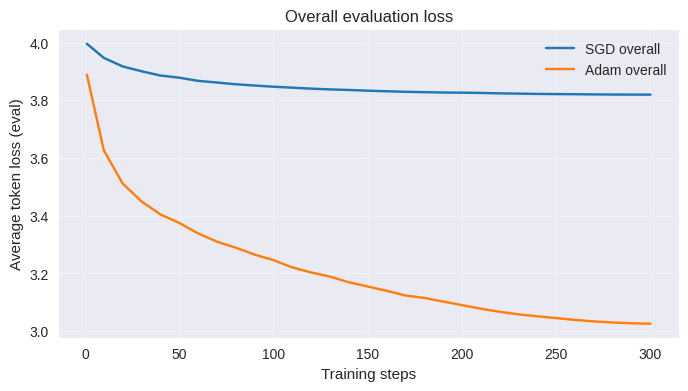

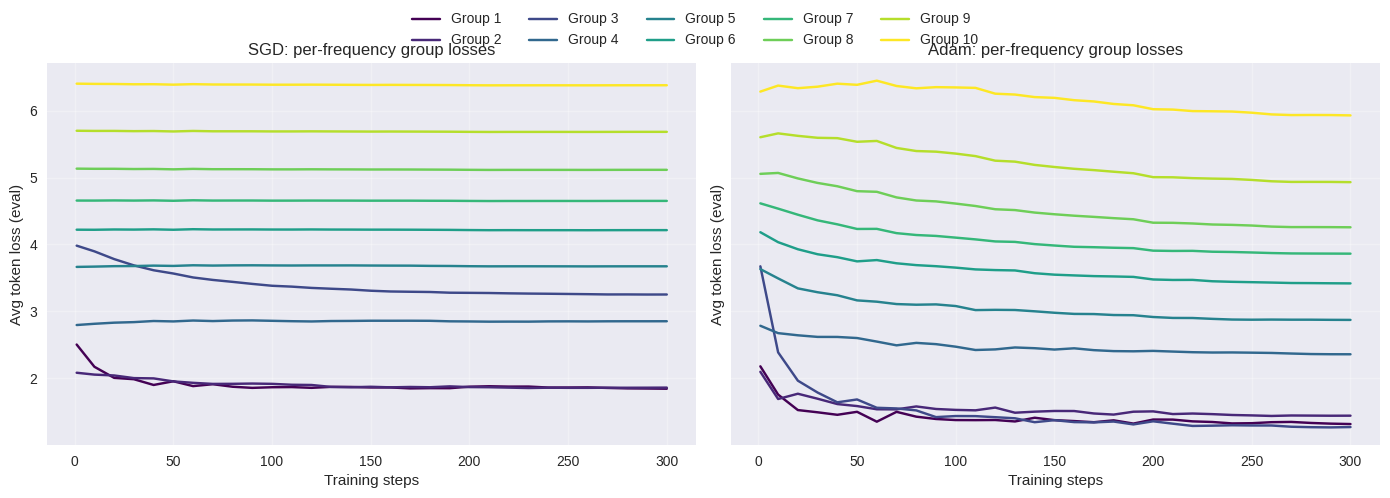

In [ ]:
def plot_results(res_sgd, res_adam, groups=10, cmap_name='viridis'):
    cmap = plt.get_cmap(cmap_name, groups)
    colors = [cmap(i) for i in range(groups)]

    # --- overall loss ---
    plt.figure(figsize=(8, 4))
    plt.plot(res_sgd['steps'], res_sgd['overall_losses'], label='SGD overall', color='tab:blue')
    plt.plot(res_adam['steps'], res_adam['overall_losses'], label='Adam overall', color='tab:orange')
    plt.xlabel('Training steps')
    plt.ylabel('Average token loss (eval)')
    plt.title('Overall evaluation loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- per-group losses ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for gi in range(groups):
        axs[0].plot(res_sgd['steps'], res_sgd['group_losses_history'][:, gi],
                    color=colors[gi], label=f'Group {gi+1}')
        axs[1].plot(res_adam['steps'], res_adam['group_losses_history'][:, gi],
                    color=colors[gi], label=f'Group {gi+1}')

    axs[0].set_title('SGD: per-frequency group losses')
    axs[1].set_title('Adam: per-frequency group losses')
    for ax in axs:
        ax.set_xlabel('Training steps')
        ax.set_ylabel('Avg token loss (eval)')
        ax.grid(True, alpha=0.3)
    # one shared legend
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=groups//2)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_results(res_sgd, res_adam)


# Experiment 2: Resnet-18 on Imagenette with 10 classes



In [ ]:
!pip install -q torch torchvision torchaudio tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xzf imagenette2-160.tgz

data_dir = "imagenette2-160/train"

# Standard ResNet transforms
train_transforms = transforms.Compose([
    transforms.Resize(160),
    transforms.RandomResizedCrop(160),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)


--2025-10-08 11:44:55--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.232.88, 52.216.8.5, 52.217.108.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.232.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  41.0MB/s    in 2.3s    

2025-10-08 11:44:58 (41.0 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]

Number of classes: 10


In [ ]:
# Compute per-class sample indices
class_indices = [[] for _ in range(num_classes)]
for idx, (_, label) in enumerate(train_dataset.samples):
    class_indices[label].append(idx)

# Target number of samples per class
total_samples = len(train_dataset)
target_samples = []

# Imbalanced: pi ∝ 1/k (k=1..num_classes)
for k in range(1, num_classes+1):
    target_samples.append(int((1/k) * total_samples / sum(1/np.array(range(1,num_classes+1)))))
print(target_samples)
# Subsample each class
imbalanced_indices = []
for k, num in enumerate(target_samples):
    inds = class_indices[k]
    if num < len(inds):
        sampled = random.sample(inds, num)
    else:
        sampled = inds
    imbalanced_indices.extend(sampled)

# Uniform subset: same total samples
uniform_indices = []
samples_per_class = len(imbalanced_indices) // num_classes
for k in range(num_classes):
    inds = class_indices[k]
    if samples_per_class < len(inds):
        sampled = random.sample(inds, samples_per_class)
    else:
        sampled = inds
    uniform_indices.extend(sampled)

# Subset datasets
from torch.utils.data import Subset
train_dataset_imbalanced = Subset(train_dataset, imbalanced_indices)
train_dataset_uniform = Subset(train_dataset, uniform_indices)

print("Imbalanced samples:", len(train_dataset_imbalanced))
print("Uniform samples:", len(train_dataset_uniform))


[3232, 1616, 1077, 808, 646, 538, 461, 404, 359, 323]
Imbalanced samples: 6450
Uniform samples: 6450


In [ ]:
batch_size = 32

train_loader_imbalanced = DataLoader(train_dataset_imbalanced, batch_size=batch_size, shuffle=True)
train_loader_uniform = DataLoader(train_dataset_uniform, batch_size=batch_size, shuffle=True)


In [ ]:
def get_model(num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [ ]:
def get_optimizer(model, lr=0.01):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)


In [ ]:
def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    per_class_loss = np.zeros(num_classes)
    per_class_count = np.zeros(num_classes)

    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # compute per-class loss
        with torch.no_grad():
            probs = nn.functional.cross_entropy(outputs, labels, reduction='none')
            for i, lbl in enumerate(labels):
                per_class_loss[lbl] += probs[i].item()
                per_class_count[lbl] += 1

    overall_loss = running_loss / len(loader.dataset)
    per_class_avg = per_class_loss / np.maximum(per_class_count, 1)
    return overall_loss, per_class_avg


In [ ]:
epochs = 5  # increase for stronger signal, keep small for Colab

# Imbalanced
model_imb = get_model(num_classes)
opt_imb = get_optimizer(model_imb)
criterion = nn.CrossEntropyLoss()
loss_history_imb = []
per_class_history_imb = []

for epoch in range(epochs):
    overall, per_class = train_one_epoch(model_imb, train_loader_imbalanced, opt_imb, criterion)
    print(f"Epoch {epoch+1} | Overall Loss: {overall:.4f}")
    loss_history_imb.append(overall)
    per_class_history_imb.append(per_class)

# Uniform
model_uni = get_model(num_classes)
opt_uni = get_optimizer(model_uni)
loss_history_uni = []
per_class_history_uni = []

for epoch in range(epochs):
    overall, per_class = train_one_epoch(model_uni, train_loader_uniform, opt_uni, criterion)
    print(f"Epoch {epoch+1} | Overall Loss: {overall:.4f}")
    loss_history_uni.append(overall)
    per_class_history_uni.append(per_class)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 202/202 [00:22<00:00,  9.11it/s]


Epoch 1 | Overall Loss: 1.9492


100%|██████████| 202/202 [00:21<00:00,  9.45it/s]


Epoch 2 | Overall Loss: 1.6795


100%|██████████| 202/202 [00:21<00:00,  9.39it/s]


Epoch 3 | Overall Loss: 1.5535


100%|██████████| 202/202 [00:21<00:00,  9.37it/s]


Epoch 4 | Overall Loss: 1.4514


100%|██████████| 202/202 [00:21<00:00,  9.33it/s]


Epoch 5 | Overall Loss: 1.3601


100%|██████████| 202/202 [00:21<00:00,  9.46it/s]


Epoch 1 | Overall Loss: 1.9820


100%|██████████| 202/202 [00:21<00:00,  9.35it/s]


Epoch 2 | Overall Loss: 1.7029


100%|██████████| 202/202 [00:21<00:00,  9.22it/s]


Epoch 3 | Overall Loss: 1.5568


100%|██████████| 202/202 [00:21<00:00,  9.29it/s]


Epoch 4 | Overall Loss: 1.4470


100%|██████████| 202/202 [00:21<00:00,  9.29it/s]

Epoch 5 | Overall Loss: 1.3781


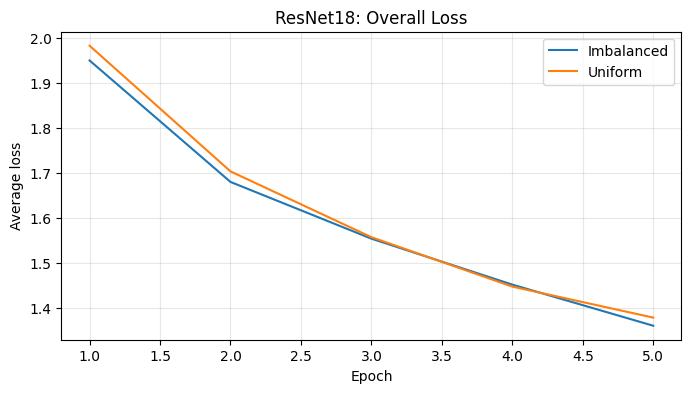

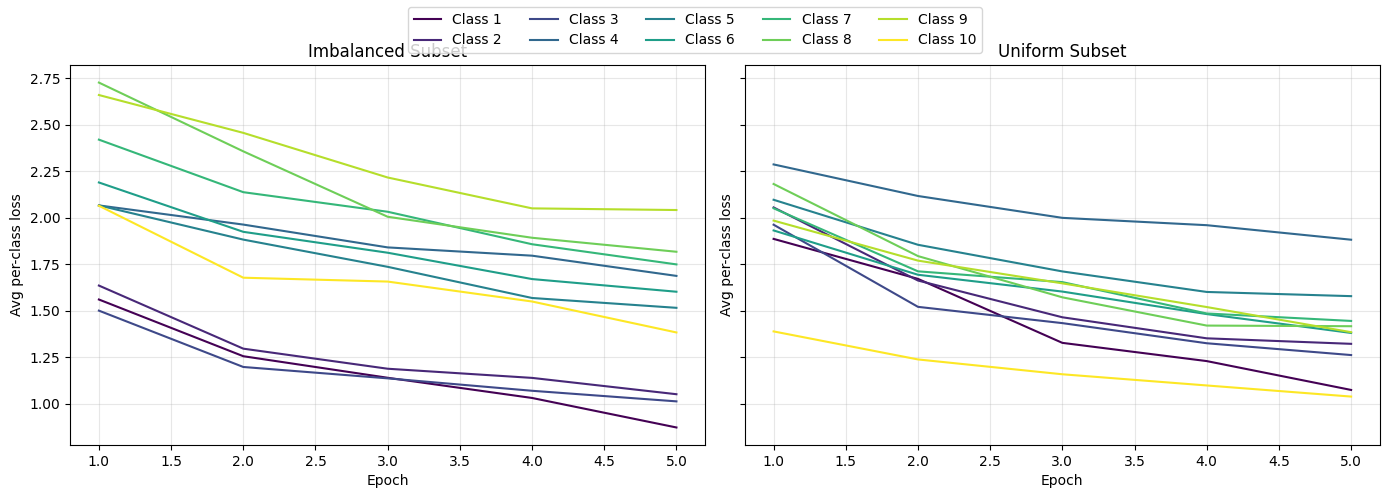

In [ ]:
# Overall loss
plt.figure(figsize=(8,4))
plt.plot(range(1, epochs+1), loss_history_imb, label='Imbalanced')
plt.plot(range(1, epochs+1), loss_history_uni, label='Uniform')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.title('ResNet18: Overall Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Per-class loss: gradual color for classes
cmap = plt.get_cmap('viridis', num_classes)
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(1,2,figsize=(14,5), sharey=True)
for ci in range(num_classes):
    per_class_vals_imb = [per_class_history_imb[e][ci] for e in range(epochs)]
    per_class_vals_uni = [per_class_history_uni[e][ci] for e in range(epochs)]
    axs[0].plot(range(1, epochs+1), per_class_vals_imb, color=colors[ci], label=f'Class {ci+1}')
    axs[1].plot(range(1, epochs+1), per_class_vals_uni, color=colors[ci], label=f'Class {ci+1}')

axs[0].set_title('Imbalanced Subset')
axs[1].set_title('Uniform Subset')
for ax in axs:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Avg per-class loss')
    ax.grid(True, alpha=0.3)
fig.legend(handles=axs[1].get_lines(), labels=[f'Class {i+1}' for i in range(num_classes)],
           loc='upper center', ncol=num_classes//2)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# Experiment 3: Resnet-18 on tiny-imagenet-200 with 200 classes

In [ ]:
# Install deps
!pip install -q torch torchvision torchaudio tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, os, zipfile, requests

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [ ]:
# ------------------------------------------------------------
# 1. DOWNLOAD tiny-IMAGENET-200 (train split only for simplicity)
# ------------------------------------------------------------
if not os.path.exists("tiny-imagenet-200/train"):
    print("Downloading tiny-imagenet-200 subset...")
    # ~13 GB total
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip tiny-imagenet-200.zip

else:
    print("tiny-imagenet-200 already available.")

data_dir = "tiny-imagenet-200/train"


Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-

In [ ]:
# ------------------------------------------------------------
# 2. DATASET + TRANSFORMS
# ------------------------------------------------------------

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

num_classes = len(train_dataset.classes)
num_samples = len(train_dataset.samples)
print(f"✅ Loaded dataset from: {data_dir}")
print(f"Number of classes: {num_classes}")
print(f"Number of image samples: {num_samples}")

# ------------------------------------------------------------
# 3. CREATE IMBALANCED AND UNIFORM SUBSETS (robust)
# ------------------------------------------------------------
# Collect all indices for each class
class_indices = [[] for _ in range(num_classes)]
for idx, (_, label) in enumerate(train_dataset.samples):
    class_indices[label].append(idx)

# Compute total number of available samples
total_samples = sum(len(v) for v in class_indices)

if total_samples < num_classes:
    print("⚠️ Warning: Fewer images than classes — imbalance will be minimal.")

# ------------------- Robust 1/k scaling relative to first class -------------------
# available samples per class
available = np.array([len(class_indices[k]) for k in range(num_classes)], dtype=int)
print("Available samples per class (first 10):", available[:10])

# Option A: base n1 on the first class in label order
n1 = available[0]

# Option B (alternative): base n1 on the dataset-wide maximum
# n1 = available.max()

# If n1 is zero (unlikely), fall back to 1
if n1 <= 0:
    n1 = 1

# Desired counts according to 1/k relative to n1
ranks = np.arange(1, num_classes + 1)
desired_by_rank = (n1 / ranks).astype(int)   # floor division effect
desired_by_rank[desired_by_rank == 0] = 1   # enforce at least 1

# Now cap by availability per class (we assume class label k corresponds to rank k here)
# If you intended a different mapping (e.g. rank by some sort order), sort/permute accordingly.
target_samples = np.minimum(desired_by_rank, available)

# If some classes have zero available, ensure we don't request them
target_samples = np.where(available > 0, target_samples, 0)

# Diagnostics
print("First 10 desired_by_rank:", desired_by_rank[:10])
print("First 10 available:", available[:10])
print("First 10 final target_samples:", target_samples[:10])
print("Total imbalanced samples to draw:", int(target_samples.sum()))

# ------------------- Subsample each class according to target_samples -------------------
imbalanced_indices = []
for k, num in enumerate(target_samples):
    inds = class_indices[k]
    if len(inds) == 0 or num == 0:
        continue
    # sample without replacement, cap by available
    sampled = random.sample(inds, min(int(num), len(inds)))
    imbalanced_indices.extend(sampled)

train_dataset_imbalanced = Subset(train_dataset, imbalanced_indices)

# ---------- Uniform subset (same total samples) ----------
uniform_indices = []
samples_per_class = max(1, len(imbalanced_indices) // max(1, num_classes))
for k in range(num_classes):
    inds = class_indices[k]
    if len(inds) == 0:
        continue
    sampled = random.sample(inds, min(samples_per_class, len(inds)))
    uniform_indices.extend(sampled)

train_dataset_uniform = Subset(train_dataset, uniform_indices)

print(f"Imbalanced subset size: {len(train_dataset_imbalanced)}")
print(f"Uniform subset size: {len(train_dataset_uniform)}")

# Optional: show per-class counts for imbalanced subset (quick sanity)
from collections import Counter
imb_counts = Counter([train_dataset.samples[i][1] for i in imbalanced_indices])
print("Imbalanced per-class counts (first 10 classes):", [imb_counts.get(i,0) for i in range(min(10, num_classes))])


print(f"Imbalanced subset size: {len(train_dataset_imbalanced)}")
print(f"Uniform subset size: {len(train_dataset_uniform)}")

# Optional: check class distribution
class_counts_imbalanced = [sum([1 for i in imbalanced_indices if train_dataset.samples[i][1] == c])
                           for c in range(num_classes)]
nonzero_classes = sum([1 for c in class_counts_imbalanced if c > 0])
print(f"Active classes in imbalanced subset: {nonzero_classes}/{num_classes}")

# ------------------------------------------------------------
# 4. DATALOADERS
# ------------------------------------------------------------
# ------------------------------------------------------------------
# Paste this block AFTER you have:
#   - created `train_dataset_imbalanced` and `train_dataset_uniform`
#   - defined `imbalanced_indices` (used for decile grouping earlier)
#   - set `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`
# ------------------------------------------------------------------

import time, os, numpy as np, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast
from collections import Counter

# ---------- USER-TUNABLE HYPERPARAMETERS ----------
batch_size = 128            # training batch size (reduce if OOM)
eval_batch = 256            # evaluation batch size
epochs = 10                  # number of epochs
evals_per_epoch = 6         # how many evals per epoch (controls frequency)
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# ---------- DATALOADERS (fast defaults) ----------
num_cpus = os.cpu_count() or 2
num_workers = min(8, max(0, num_cpus - 1))
pin_memory = True
persistent_workers = True
prefetch_factor = 2

train_loader_imbalanced = DataLoader(
    train_dataset_imbalanced,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor
)

train_loader_uniform = DataLoader(
    train_dataset_uniform,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor
)

# ---------------------- create smaller eval subsets ----------------------
eval_fraction = 0.1  # keep 10% of the dataset for evaluation

# imbalanced eval subset
num_eval_imb = max(1, int(len(train_dataset_imbalanced) * eval_fraction))
eval_indices_imbalanced = random.sample(range(len(train_dataset_imbalanced)), num_eval_imb)
eval_dataset_imbalanced_small = Subset(train_dataset_imbalanced, eval_indices_imbalanced)
# uniform eval subset
num_eval_uni = max(1, int(len(train_dataset_uniform) * eval_fraction))
eval_indices_uniform = random.sample(range(len(train_dataset_uniform)), num_eval_uni)
eval_dataset_uniform_small = Subset(train_dataset_uniform, eval_indices_uniform)

# ---------------------- small eval dataloaders ----------------------
eval_loader_imbalanced = DataLoader(
    eval_dataset_imbalanced_small,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

eval_loader_uniform = DataLoader(
    eval_dataset_uniform_small,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

print(f"✅ Small eval loaders: {len(eval_dataset_imbalanced_small)} imbalanced, {len(eval_dataset_uniform_small)} uniform")
# ---------- SPEED FLAGS ----------
torch.backends.cudnn.benchmark = True
USE_TORCH_COMPILE = hasattr(torch, "compile")

# ---------- MODEL & OPTIMIZERS (train only final FC) ----------
num_classes = len(train_dataset.classes)

def get_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # ❌ remove or comment out these lines:
    # for param in model.parameters():
    #     param.requires_grad = False

    # ✅ keep the classification head replacement
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model = model.to(device)

    # optional compile
    if USE_TORCH_COMPILE:
        try:
            model = torch.compile(model)
        except Exception:
            pass
    return model


def get_sgd(model, lr=0.01):
    return optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

def get_adam(model, lr=1e-3):
    return optim.Adam(model.fc.parameters(), lr=lr, weight_decay=1e-4)

# ---------- evaluation helper (per-class losses) ----------
loss_fn_per_sample = nn.CrossEntropyLoss(reduction='none')

def evaluate_per_class(model, loader):
    model.eval()
    per_class_loss = np.zeros(num_classes, dtype=float)
    per_class_count = np.zeros(num_classes, dtype=int)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            logits = model(inputs)
            losses = loss_fn_per_sample(logits, labels)  # shape (B,)
            total_loss += losses.sum().item()
            total_samples += labels.size(0)
            lbls_cpu = labels.cpu().numpy()
            for i, lbl in enumerate(lbls_cpu):
                per_class_loss[lbl] += float(losses[i].item())
                per_class_count[lbl] += 1
    per_class_avg = per_class_loss / np.maximum(per_class_count, 1)
    overall_avg = total_loss / max(1, total_samples)
    return overall_avg, per_class_avg, per_class_count

# ---------- improved decile grouping so each decile has ~10% of the SAMPLES ----------
# requires `imbalanced_indices` (list of dataset indices used in imbalanced subset)

from collections import Counter

# per-class counts in the imbalanced subset
imbalanced_labels = [train_dataset.samples[idx][1] for idx in imbalanced_indices]
class_counts = Counter(imbalanced_labels)
class_freqs = np.array([class_counts.get(c, 0) for c in range(num_classes)], dtype=int)
print("class freqs (first 20):", class_freqs[:20])

# sort classes by descending frequency (class indices)
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]

total_samples_in_subset = sorted_counts.sum()
if total_samples_in_subset == 0:
    raise ValueError("Imbalanced subset has zero samples.")
print("total samples in imbalanced subset:", total_samples_in_subset)

# desired cumulative cut points (10%, 20%, ..., 90%) - we will create 10 bins
n_bins = 10
cuts = [total_samples_in_subset * i / n_bins for i in range(1, n_bins)]  # 9 cut thresholds

# cumulative sums over sorted counts
cumsum = np.cumsum(sorted_counts)

# find class indices where cuts are crossed
cut_positions = np.searchsorted(cumsum, cuts, side='left')  # indices into sorted_classes_desc

# now build bins by slicing sorted_classes_desc
decile_indices = []
prev = 0
for pos in cut_positions:
    # slice classes from prev .. pos (inclusive pos)
    if pos < prev:
        pos = prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])  # include pos to ensure progress
    prev = pos+1
# last bin: remaining classes
decile_indices.append(sorted_classes_desc[prev:])

# If some bins ended up empty (possible for extreme distributions), fix by moving classes
# from neighboring bins until none are empty.
for i in range(len(decile_indices)):
    if len(decile_indices[i]) == 0:
        # try borrow from next bin
        j = i+1
        while j < len(decile_indices) and len(decile_indices[j]) == 0:
            j += 1
        if j < len(decile_indices) and len(decile_indices[j]) > 1:
            # move the first class of j to i
            decile_indices[i] = np.array([decile_indices[j][0]])
            decile_indices[j] = decile_indices[j][1:]
        else:
            # otherwise borrow from previous bin
            j = i-1
            while j >= 0 and len(decile_indices[j]) <= 1:
                j -= 1
            if j >= 0:
                decile_indices[i] = np.array([decile_indices[j][-1]])
                decile_indices[j] = decile_indices[j][:-1]
            else:
                # last-resort: leave empty (rare)
                pass

# Final diagnostics: compute sample counts per decile
decile_counts = np.array([class_freqs[inds].sum() if len(inds) > 0 else 0 for inds in decile_indices])
print("decile sample counts (final):", decile_counts, "sum:", decile_counts.sum())
most_freq_decile = int(np.argmax(decile_counts))
print("most_freq_decile (0-indexed):", most_freq_decile)
num_deciles = len(decile_indices)
print("num_deciles:", num_deciles)

# Optionally show number of classes per decile
print("classes per decile:", [len(inds) for inds in decile_indices])


# ---------------------- Balanced per-class eval subsets (k per class) ----------------------
from collections import defaultdict

k_per_class = 5   # <--- choose how many samples per class for balanced eval (5 is a good default)

def build_balanced_eval_subset(full_subset_indices, dataset_obj, k=k_per_class):
    """
    full_subset_indices: list of indices into dataset_obj (these are the indices of the training subset)
    dataset_obj: the original full train_dataset (so dataset_obj.samples[idx][1] -> label)
    returns: a list of dataset indices forming the balanced eval subset
    """
    # collect indices per class (but indices are indices into dataset_obj)
    per_class = defaultdict(list)
    for idx in full_subset_indices:
        lbl = dataset_obj.samples[idx][1]
        per_class[lbl].append(idx)

    # sample up to k per class
    chosen = []
    for c, inds in per_class.items():
        if len(inds) == 0:
            continue
        n_take = min(k, len(inds))
        # sample deterministically for reproducibility? you can use random.sample for random
        chosen_inds = random.sample(inds, n_take)
        chosen.extend(chosen_inds)
    return chosen

# Build balanced eval indices for imbalanced subset (we use imbalanced_indices which are dataset indices)
balanced_eval_indices_imbalanced = build_balanced_eval_subset(imbalanced_indices, train_dataset, k=k_per_class)

# For uniform subset, we used "uniform_indices" above (dataset indices). If not available, create it similarly.
# uniform_indices should exist from earlier code. If you used different variable names, adapt accordingly.
balanced_eval_indices_uniform = build_balanced_eval_subset(uniform_indices, train_dataset, k=k_per_class)

# Convert to Subsets (these are Subset objects indexing into the original train_dataset)
balanced_eval_dataset_imbalanced = Subset(train_dataset, balanced_eval_indices_imbalanced)
balanced_eval_dataset_uniform = Subset(train_dataset, balanced_eval_indices_uniform)

# Create DataLoaders for balanced evals (small and cheap)
eval_batch = min(256, max(1, len(balanced_eval_indices_imbalanced)))  # reuse eval_batch variable but safe
balanced_eval_loader_imbalanced = DataLoader(
    balanced_eval_dataset_imbalanced,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

balanced_eval_loader_uniform = DataLoader(
    balanced_eval_dataset_uniform,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

print(f"Balanced eval: imbalanced subset -> {len(balanced_eval_dataset_imbalanced)} samples ({k_per_class} per active class)")
print(f"Balanced eval: uniform subset    -> {len(balanced_eval_dataset_uniform)} samples ({k_per_class} per active class)")

# ---------------------- Use balanced eval loaders in your runner ----------------------
# In the run_experiment function you used small_train_eval_loader = eval_loader_imbalanced / eval_loader_uniform.
# Replace those with the balanced loaders:
#
#    if dataset == 'imbalanced':
#        train_loader = train_loader_imbalanced
#        small_train_eval_loader = balanced_eval_loader_imbalanced
#    else:
#        train_loader = train_loader_uniform
#        small_train_eval_loader = balanced_eval_loader_uniform
#
# If you want, paste the exact updated run_experiment below (complete replacement):

def run_experiment(optimizer_name='sgd', dataset='imbalanced', lr=None):
    """
    Records training losses per batch separately from evaluation snapshots.
    - train_steps / train_losses: recorded every batch (fine-grained)
    - eval_steps / per_class_history: recorded at init, periodic evals, and epoch-end (coarse snapshots)
    Returns both sets for correct plotting.
    """
    if dataset == 'imbalanced':
        train_loader = train_loader_imbalanced
        small_train_eval_loader = balanced_eval_loader_imbalanced
    else:
        train_loader = train_loader_uniform
        small_train_eval_loader = balanced_eval_loader_uniform

    model = get_model(num_classes)
    if optimizer_name.lower() == 'sgd':
        opt = get_sgd(model, lr=(0.01 if lr is None else lr))
    elif optimizer_name.lower() == 'adam':
        opt = get_adam(model, lr=(1e-3 if lr is None else lr))
    else:
        raise ValueError("optimizer must be 'sgd' or 'adam'")

    scaler = GradScaler()
    batches_per_epoch = len(train_loader)
    eval_interval = max(1, batches_per_epoch // max(1, evals_per_epoch))

    # storage: separate train vs eval
    train_steps = []
    train_losses = []
    eval_steps = []
    per_class_hist = []
    global_step = 0

    # ---------- initial "step 0" training-loss estimate ----------
    try:
        first_batch = next(iter(train_loader))
        inputs0, labels0 = first_batch
        inputs0, labels0 = inputs0.to(device, non_blocking=True), labels0.to(device, non_blocking=True)
        model.eval()
        with torch.no_grad():
            logits0 = model(inputs0)
            loss0 = nn.functional.cross_entropy(logits0, labels0).item()
    except Exception:
        loss0 = float('nan')

    # record initial training estimate (not a batch step)
    # note: do NOT put this into train_steps (since no training step executed yet)
    # keep as eval snapshot at step 0
    eval_steps.append(0)
    per_class_avg0, pc_avg0, pc_cnt0 = None, None, None
    ov, pc_avg, pc_cnt = evaluate_per_class(model, small_train_eval_loader)
    per_class_hist.append(pc_avg.copy())

    print(f"[Init] {optimizer_name.upper()} on {dataset}: train-batch-loss-estimate={loss0:.4f}, balanced-small-train-eval-loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        epoch_start = time.time()
        pbar = tqdm(train_loader, desc=f"{optimizer_name.upper()}-{dataset} EP{ep+1}", leave=False)
        for bidx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            opt.zero_grad()

            with autocast():
                logits = model(inputs)
                loss = nn.functional.cross_entropy(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            global_step += 1

            # record train loss for this batch
            train_steps.append(global_step)
            train_losses.append(loss.item())

            # update pbar occasionally
            if bidx % max(1, (eval_interval // 2)) == 0:
                pbar.set_postfix({'batch_loss': f"{loss.item():.4f}"})
                pbar.refresh()

            # periodic eval snapshot (cheap balanced per-class eval)
            if global_step % eval_interval == 0:
                model.eval()
                ov_small, pc_avg_small, pc_cnt_small = evaluate_per_class(model, small_train_eval_loader)
                eval_steps.append(global_step)
                per_class_hist.append(pc_avg_small.copy())
                print(f"   Eval snapshot @ step {global_step}: balanced-small-train-loss={ov_small:.4f}", flush=True)
                model.train()

        # end-of-epoch snapshot (even if last batch already triggered an eval, it's fine to capture again)
        model.eval()
        ov_small, pc_avg_small, pc_cnt_small = evaluate_per_class(model, small_train_eval_loader)
        eval_steps.append(global_step)
        per_class_hist.append(pc_avg_small.copy())
        print(f"[Epoch {ep+1}] {optimizer_name.upper()} on {dataset}: balanced-small-train-loss={ov_small:.4f}  (epoch time {time.time()-epoch_start:.1f}s)")
        model.train()

    # convert histories to arrays
    per_class_arr = np.stack(per_class_hist)  # shape (T_eval, num_classes)

    return {
        'optimizer': optimizer_name,
        'dataset': dataset,
        # training (per-batch)
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        # evaluation snapshots (coarse)
        'eval_steps': np.array(eval_steps),
        'per_class_history': per_class_arr,   # rows correspond to eval_steps
        # compatibility fields (old names) — overall_losses kept as train_losses for backward compatibility
        'steps': np.array(train_steps),
        'overall_losses': np.array(train_losses),
    }



# ---------- USAGE EXAMPLE ----------
# res_sgd_imb = run_experiment('sgd', 'imbalanced')
# res_adam_imb = run_experiment('adam', 'imbalanced')
# res_sgd_uni = run_experiment('sgd', 'uniform')
# res_adam_uni = run_experiment('adam', 'uniform')

print("Helper block loaded — call run_experiment(...) to run trials.")


✅ Loaded dataset from: tiny-imagenet-200/train
Number of classes: 200
Number of image samples: 100000
Available samples per class (first 10): [500 500 500 500 500 500 500 500 500 500]
First 10 desired_by_rank: [500 250 166 125 100  83  71  62  55  50]
First 10 available: [500 500 500 500 500 500 500 500 500 500]
First 10 final target_samples: [500 250 166 125 100  83  71  62  55  50]
Total imbalanced samples to draw: 2840
Imbalanced subset size: 2840
Uniform subset size: 2800
Imbalanced per-class counts (first 10 classes): [500, 250, 166, 125, 100, 83, 71, 62, 55, 50]
Imbalanced subset size: 2840
Uniform subset size: 2800
Active classes in imbalanced subset: 200/200
✅ Small eval loaders: 284 imbalanced, 280 uniform
class freqs (first 20): [500 250 166 125 100  83  71  62  55  50  45  41  38  35  33  31  29  27
  26  25]
total samples in imbalanced subset: 2840
decile sample counts (final): [500 250 166 225 321 252 287 272 284 283] sum: 2840
most_freq_decile (0-indexed): 0
num_deciles: 

In [ ]:
import pandas as pd
import numpy as np
import os

# make sure results folder exists
results_dir = "experiment_results"
os.makedirs(results_dir, exist_ok=True)

# ---------------- HELPER: PER-DECILE HISTORY ----------------
def per_decile_history(res):
    """
    Build decile history from res['per_class_history'] (shape: T_eval x num_classes).
    Use np.nanmean to ignore classes with no samples in the balanced eval.
    Returns decile_hist shape (num_deciles, T_eval).
    """
    per_class_hist = res['per_class_history']  # shape (T_eval, num_classes)
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan, dtype=float)
    for d, inds in enumerate(decile_indices):
        if len(inds) == 0:
            continue
        # take nanmean across the selected class columns
        decile_hist[d, :] = np.nanmean(per_class_hist[:, inds], axis=1)
    return decile_hist

# ---------------- SAVE CSV HELPERS ----------------
def save_decile_history_csv(decile_hist, eval_steps, opt_name, dataset_name):
    """
    decile_hist: (num_deciles, T_eval)
    eval_steps: length T_eval (x-axis for decile snapshots)
    """
    df = pd.DataFrame(decile_hist.T, columns=[f"Decile_{i+1}" for i in range(decile_hist.shape[0])])
    df.insert(0, "Step", eval_steps)
    file_path = os.path.join(results_dir, f"{opt_name}_{dataset_name}_deciles.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved decile history to {file_path}")

def save_overall_loss_csv(train_losses, train_steps, opt_name, dataset_name):
    df = pd.DataFrame({"Step": train_steps, "Overall_Loss": train_losses})
    file_path = os.path.join(results_dir, f"{opt_name}_{dataset_name}_overall.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved overall loss to {file_path}")

# ---------------- RUN ALL FOUR EXPERIMENTS (updated) ----------------
experiments = [
    ('sgd', 'imbalanced'),
    ('adam', 'imbalanced'),
    ('sgd', 'uniform'),
    ('adam', 'uniform')
]

results = {}
for opt_name, dataset_name in experiments:
    print(f"\n=== Running {opt_name.upper()} on {dataset_name} ===")
    res = run_experiment(opt_name, dataset_name)

    # get train/eval arrays (backwards-compatible aliases exist too)
    train_steps = res.get('train_steps', res.get('steps', np.array([], dtype=int)))
    train_losses = res.get('train_losses', res.get('overall_losses', np.array([], dtype=float)))
    eval_steps = res.get('eval_steps', np.array([], dtype=int))
    per_class_history = res['per_class_history']  # shape (T_eval, num_classes)

    # compute decile history (aligned with eval_steps) and save CSV (use eval_steps)
    if per_class_history.size > 0 and eval_steps.size > 0:
        decile_hist = per_decile_history(res)  # shape (num_deciles, T_eval)
        save_decile_history_csv(decile_hist, eval_steps, opt_name, dataset_name)
    else:
        print("Warning: no eval snapshots found; skipping decile CSV.")

    # save overall training loss CSV (use train_steps)
    if train_losses.size > 0 and train_steps.size > 0:
        save_overall_loss_csv(train_losses, train_steps, opt_name, dataset_name)
    else:
        print("Warning: no train losses found; skipping overall CSV.")

    # store in memory
    results[f"{opt_name}_{dataset_name}"] = res

print("\nAll experiments completed and saved.")



=== Running SGD on imbalanced ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]
/tmp/ipython-input-4260978966.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
W1013 16:09:41.965000 2018 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


[Init] SGD on imbalanced: train-batch-loss-estimate=5.4052, balanced-small-train-eval-loss=5.4764


SGD-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-4260978966.py:468: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-4260978966.py:468: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5212
   Eval snapshot @ step 6: balanced-small-train-loss=5.9107
   Eval snapshot @ step 9: balanced-small-train-loss=5.7962
   Eval snapshot @ step 12: balanced-small-train-loss=5.9617
   Eval snapshot @ step 15: balanced-small-train-loss=5.7968
   Eval snapshot @ step 18: balanced-small-train-loss=5.7718
   Eval snapshot @ step 21: balanced-small-train-loss=5.7271
[Epoch 1] SGD on imbalanced: balanced-small-train-loss=5.7677  (epoch time 93.8s)


SGD-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.7385
   Eval snapshot @ step 27: balanced-small-train-loss=5.5730
   Eval snapshot @ step 30: balanced-small-train-loss=5.5415
   Eval snapshot @ step 33: balanced-small-train-loss=5.4866
   Eval snapshot @ step 36: balanced-small-train-loss=5.4801
   Eval snapshot @ step 39: balanced-small-train-loss=5.5427
   Eval snapshot @ step 42: balanced-small-train-loss=5.5253
   Eval snapshot @ step 45: balanced-small-train-loss=5.3991
[Epoch 2] SGD on imbalanced: balanced-small-train-loss=5.4177  (epoch time 38.8s)


SGD-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.3794
   Eval snapshot @ step 51: balanced-small-train-loss=5.3203
   Eval snapshot @ step 54: balanced-small-train-loss=5.3989
   Eval snapshot @ step 57: balanced-small-train-loss=5.3557
   Eval snapshot @ step 60: balanced-small-train-loss=5.1729
   Eval snapshot @ step 63: balanced-small-train-loss=5.0933
   Eval snapshot @ step 66: balanced-small-train-loss=5.1191
   Eval snapshot @ step 69: balanced-small-train-loss=5.1290
[Epoch 3] SGD on imbalanced: balanced-small-train-loss=5.1156  (epoch time 38.0s)


SGD-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=5.1229
   Eval snapshot @ step 75: balanced-small-train-loss=5.0814
   Eval snapshot @ step 78: balanced-small-train-loss=5.0378
   Eval snapshot @ step 81: balanced-small-train-loss=5.0477
   Eval snapshot @ step 84: balanced-small-train-loss=5.1198
   Eval snapshot @ step 87: balanced-small-train-loss=5.1031
   Eval snapshot @ step 90: balanced-small-train-loss=4.9402
[Epoch 4] SGD on imbalanced: balanced-small-train-loss=4.9284  (epoch time 35.1s)


SGD-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=4.8627
   Eval snapshot @ step 96: balanced-small-train-loss=4.8624
   Eval snapshot @ step 99: balanced-small-train-loss=4.8208
   Eval snapshot @ step 102: balanced-small-train-loss=4.9050
   Eval snapshot @ step 105: balanced-small-train-loss=4.8437
   Eval snapshot @ step 108: balanced-small-train-loss=4.7914
   Eval snapshot @ step 111: balanced-small-train-loss=4.8205
   Eval snapshot @ step 114: balanced-small-train-loss=4.8087
[Epoch 5] SGD on imbalanced: balanced-small-train-loss=4.7476  (epoch time 38.6s)


SGD-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=4.7712
   Eval snapshot @ step 120: balanced-small-train-loss=4.7335
   Eval snapshot @ step 123: balanced-small-train-loss=4.6944
   Eval snapshot @ step 126: balanced-small-train-loss=4.6676
   Eval snapshot @ step 129: balanced-small-train-loss=4.6381
   Eval snapshot @ step 132: balanced-small-train-loss=4.6156
   Eval snapshot @ step 135: balanced-small-train-loss=4.5476
   Eval snapshot @ step 138: balanced-small-train-loss=4.5964
[Epoch 6] SGD on imbalanced: balanced-small-train-loss=4.5460  (epoch time 39.3s)


SGD-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=4.5499
   Eval snapshot @ step 144: balanced-small-train-loss=4.5772
   Eval snapshot @ step 147: balanced-small-train-loss=4.5789
   Eval snapshot @ step 150: balanced-small-train-loss=4.5561
   Eval snapshot @ step 153: balanced-small-train-loss=4.5149
   Eval snapshot @ step 156: balanced-small-train-loss=4.4580
   Eval snapshot @ step 159: balanced-small-train-loss=4.4562
[Epoch 7] SGD on imbalanced: balanced-small-train-loss=4.4205  (epoch time 35.3s)


SGD-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=4.4598
   Eval snapshot @ step 165: balanced-small-train-loss=4.4733
   Eval snapshot @ step 168: balanced-small-train-loss=4.4355
   Eval snapshot @ step 171: balanced-small-train-loss=4.4650
   Eval snapshot @ step 174: balanced-small-train-loss=4.3847
   Eval snapshot @ step 177: balanced-small-train-loss=4.2742
   Eval snapshot @ step 180: balanced-small-train-loss=4.3194
   Eval snapshot @ step 183: balanced-small-train-loss=4.3040
[Epoch 8] SGD on imbalanced: balanced-small-train-loss=4.2609  (epoch time 38.9s)


SGD-imbalanced EP9:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 186: balanced-small-train-loss=4.2894
   Eval snapshot @ step 189: balanced-small-train-loss=4.2493
   Eval snapshot @ step 192: balanced-small-train-loss=4.2120
   Eval snapshot @ step 195: balanced-small-train-loss=4.2540
   Eval snapshot @ step 198: balanced-small-train-loss=4.3094
   Eval snapshot @ step 201: balanced-small-train-loss=4.2554
   Eval snapshot @ step 204: balanced-small-train-loss=4.2415
   Eval snapshot @ step 207: balanced-small-train-loss=4.1727
[Epoch 9] SGD on imbalanced: balanced-small-train-loss=4.1946  (epoch time 39.1s)


SGD-imbalanced EP10:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 210: balanced-small-train-loss=4.2062
   Eval snapshot @ step 213: balanced-small-train-loss=4.2602
   Eval snapshot @ step 216: balanced-small-train-loss=4.2669
   Eval snapshot @ step 219: balanced-small-train-loss=4.1465
   Eval snapshot @ step 222: balanced-small-train-loss=4.0861
   Eval snapshot @ step 225: balanced-small-train-loss=4.0406
   Eval snapshot @ step 228: balanced-small-train-loss=4.0830
[Epoch 10] SGD on imbalanced: balanced-small-train-loss=4.0248  (epoch time 35.5s)
Saved decile history to experiment_results/sgd_imbalanced_deciles.csv
Saved overall loss to experiment_results/sgd_imbalanced_overall.csv

=== Running ADAM on imbalanced ===


/tmp/ipython-input-4260978966.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] ADAM on imbalanced: train-batch-loss-estimate=5.6937, balanced-small-train-eval-loss=5.4881


ADAM-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-4260978966.py:468: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5421
   Eval snapshot @ step 6: balanced-small-train-loss=5.8313
   Eval snapshot @ step 9: balanced-small-train-loss=6.2164
   Eval snapshot @ step 12: balanced-small-train-loss=6.4576
   Eval snapshot @ step 15: balanced-small-train-loss=6.4865
   Eval snapshot @ step 18: balanced-small-train-loss=6.2579
   Eval snapshot @ step 21: balanced-small-train-loss=6.0523
[Epoch 1] ADAM on imbalanced: balanced-small-train-loss=5.9504  (epoch time 36.0s)


ADAM-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.9218
   Eval snapshot @ step 27: balanced-small-train-loss=5.7961
   Eval snapshot @ step 30: balanced-small-train-loss=5.7283
   Eval snapshot @ step 33: balanced-small-train-loss=5.6342
   Eval snapshot @ step 36: balanced-small-train-loss=5.5907
   Eval snapshot @ step 39: balanced-small-train-loss=5.4541
   Eval snapshot @ step 42: balanced-small-train-loss=5.3739
   Eval snapshot @ step 45: balanced-small-train-loss=5.3413
[Epoch 2] ADAM on imbalanced: balanced-small-train-loss=5.2965  (epoch time 39.0s)


ADAM-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.2953
   Eval snapshot @ step 51: balanced-small-train-loss=5.2808
   Eval snapshot @ step 54: balanced-small-train-loss=5.2364
   Eval snapshot @ step 57: balanced-small-train-loss=5.2078
   Eval snapshot @ step 60: balanced-small-train-loss=5.1523
   Eval snapshot @ step 63: balanced-small-train-loss=5.1178
   Eval snapshot @ step 66: balanced-small-train-loss=5.0494
   Eval snapshot @ step 69: balanced-small-train-loss=5.0208
[Epoch 3] ADAM on imbalanced: balanced-small-train-loss=4.9899  (epoch time 38.9s)


ADAM-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=4.9952
   Eval snapshot @ step 75: balanced-small-train-loss=4.9516
   Eval snapshot @ step 78: balanced-small-train-loss=4.9414
   Eval snapshot @ step 81: balanced-small-train-loss=4.8591
   Eval snapshot @ step 84: balanced-small-train-loss=4.7993
   Eval snapshot @ step 87: balanced-small-train-loss=4.7023
   Eval snapshot @ step 90: balanced-small-train-loss=4.6132
[Epoch 4] ADAM on imbalanced: balanced-small-train-loss=4.6443  (epoch time 35.1s)


ADAM-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=4.5980
   Eval snapshot @ step 96: balanced-small-train-loss=4.6204
   Eval snapshot @ step 99: balanced-small-train-loss=4.5719
   Eval snapshot @ step 102: balanced-small-train-loss=4.5546
   Eval snapshot @ step 105: balanced-small-train-loss=4.5347
   Eval snapshot @ step 108: balanced-small-train-loss=4.4639
   Eval snapshot @ step 111: balanced-small-train-loss=4.3955
   Eval snapshot @ step 114: balanced-small-train-loss=4.3365
[Epoch 5] ADAM on imbalanced: balanced-small-train-loss=4.3186  (epoch time 38.1s)


ADAM-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=4.3309
   Eval snapshot @ step 120: balanced-small-train-loss=4.2934
   Eval snapshot @ step 123: balanced-small-train-loss=4.2850
   Eval snapshot @ step 126: balanced-small-train-loss=4.2759
   Eval snapshot @ step 129: balanced-small-train-loss=4.2686
   Eval snapshot @ step 132: balanced-small-train-loss=4.2149
   Eval snapshot @ step 135: balanced-small-train-loss=4.1401
   Eval snapshot @ step 138: balanced-small-train-loss=4.0994
[Epoch 6] ADAM on imbalanced: balanced-small-train-loss=4.0439  (epoch time 38.4s)


ADAM-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=4.0305
   Eval snapshot @ step 144: balanced-small-train-loss=4.0292
   Eval snapshot @ step 147: balanced-small-train-loss=4.0308
   Eval snapshot @ step 150: balanced-small-train-loss=3.9748
   Eval snapshot @ step 153: balanced-small-train-loss=3.9390
   Eval snapshot @ step 156: balanced-small-train-loss=3.9137
   Eval snapshot @ step 159: balanced-small-train-loss=3.8314
[Epoch 7] ADAM on imbalanced: balanced-small-train-loss=3.9099  (epoch time 35.5s)


ADAM-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=3.8601
   Eval snapshot @ step 165: balanced-small-train-loss=3.8780
   Eval snapshot @ step 168: balanced-small-train-loss=3.8738
   Eval snapshot @ step 171: balanced-small-train-loss=3.7905
   Eval snapshot @ step 174: balanced-small-train-loss=3.7840
   Eval snapshot @ step 177: balanced-small-train-loss=3.7923
   Eval snapshot @ step 180: balanced-small-train-loss=3.6868
   Eval snapshot @ step 183: balanced-small-train-loss=3.6326
[Epoch 8] ADAM on imbalanced: balanced-small-train-loss=3.6035  (epoch time 37.9s)


ADAM-imbalanced EP9:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 186: balanced-small-train-loss=3.5848
   Eval snapshot @ step 189: balanced-small-train-loss=3.5789
   Eval snapshot @ step 192: balanced-small-train-loss=3.5991
   Eval snapshot @ step 195: balanced-small-train-loss=3.6414
   Eval snapshot @ step 198: balanced-small-train-loss=3.5648
   Eval snapshot @ step 201: balanced-small-train-loss=3.4655
   Eval snapshot @ step 204: balanced-small-train-loss=3.4617
   Eval snapshot @ step 207: balanced-small-train-loss=3.4768
[Epoch 9] ADAM on imbalanced: balanced-small-train-loss=3.5007  (epoch time 37.9s)


ADAM-imbalanced EP10:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 210: balanced-small-train-loss=3.5017
   Eval snapshot @ step 213: balanced-small-train-loss=3.4656
   Eval snapshot @ step 216: balanced-small-train-loss=3.4367
   Eval snapshot @ step 219: balanced-small-train-loss=3.3320
   Eval snapshot @ step 222: balanced-small-train-loss=3.3514
   Eval snapshot @ step 225: balanced-small-train-loss=3.2587
   Eval snapshot @ step 228: balanced-small-train-loss=3.2748
[Epoch 10] ADAM on imbalanced: balanced-small-train-loss=3.2118  (epoch time 35.4s)
Saved decile history to experiment_results/adam_imbalanced_deciles.csv
Saved overall loss to experiment_results/adam_imbalanced_overall.csv

=== Running SGD on uniform ===


/tmp/ipython-input-4260978966.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] SGD on uniform: train-batch-loss-estimate=5.4949, balanced-small-train-eval-loss=5.5236


SGD-uniform EP1:   0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipython-input-4260978966.py:468: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5043
   Eval snapshot @ step 6: balanced-small-train-loss=5.4542
   Eval snapshot @ step 9: balanced-small-train-loss=5.3651
   Eval snapshot @ step 12: balanced-small-train-loss=5.3336
   Eval snapshot @ step 15: balanced-small-train-loss=5.2677
   Eval snapshot @ step 18: balanced-small-train-loss=5.2229
   Eval snapshot @ step 21: balanced-small-train-loss=5.1754
[Epoch 1] SGD on uniform: balanced-small-train-loss=5.1556  (epoch time 51.7s)


SGD-uniform EP2:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.1593
   Eval snapshot @ step 27: balanced-small-train-loss=5.1099
   Eval snapshot @ step 30: balanced-small-train-loss=5.0726
   Eval snapshot @ step 33: balanced-small-train-loss=5.0507
   Eval snapshot @ step 36: balanced-small-train-loss=4.9852
   Eval snapshot @ step 39: balanced-small-train-loss=4.9422
   Eval snapshot @ step 42: balanced-small-train-loss=4.8688
[Epoch 2] SGD on uniform: balanced-small-train-loss=4.8470  (epoch time 42.7s)


SGD-uniform EP3:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 45: balanced-small-train-loss=4.8466
   Eval snapshot @ step 48: balanced-small-train-loss=4.8308
   Eval snapshot @ step 51: balanced-small-train-loss=4.8069
   Eval snapshot @ step 54: balanced-small-train-loss=4.7531
   Eval snapshot @ step 57: balanced-small-train-loss=4.7147
   Eval snapshot @ step 60: balanced-small-train-loss=4.6572
   Eval snapshot @ step 63: balanced-small-train-loss=4.6185
   Eval snapshot @ step 66: balanced-small-train-loss=4.5568
[Epoch 3] SGD on uniform: balanced-small-train-loss=4.5391  (epoch time 47.3s)


SGD-uniform EP4:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 69: balanced-small-train-loss=4.5164
   Eval snapshot @ step 72: balanced-small-train-loss=4.5309
   Eval snapshot @ step 75: balanced-small-train-loss=4.4839
   Eval snapshot @ step 78: balanced-small-train-loss=4.4726
   Eval snapshot @ step 81: balanced-small-train-loss=4.4066
   Eval snapshot @ step 84: balanced-small-train-loss=4.3699
   Eval snapshot @ step 87: balanced-small-train-loss=4.3477
[Epoch 4] SGD on uniform: balanced-small-train-loss=4.2836  (epoch time 42.4s)


SGD-uniform EP5:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 90: balanced-small-train-loss=4.2950
   Eval snapshot @ step 93: balanced-small-train-loss=4.2770
   Eval snapshot @ step 96: balanced-small-train-loss=4.2367
   Eval snapshot @ step 99: balanced-small-train-loss=4.2403
   Eval snapshot @ step 102: balanced-small-train-loss=4.1896
   Eval snapshot @ step 105: balanced-small-train-loss=4.1576
   Eval snapshot @ step 108: balanced-small-train-loss=4.0968
[Epoch 5] SGD on uniform: balanced-small-train-loss=4.0811  (epoch time 42.8s)


SGD-uniform EP6:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 111: balanced-small-train-loss=4.0710
   Eval snapshot @ step 114: balanced-small-train-loss=4.0606
   Eval snapshot @ step 117: balanced-small-train-loss=4.0621
   Eval snapshot @ step 120: balanced-small-train-loss=4.0270
   Eval snapshot @ step 123: balanced-small-train-loss=3.9999
   Eval snapshot @ step 126: balanced-small-train-loss=3.9538
   Eval snapshot @ step 129: balanced-small-train-loss=3.9089
   Eval snapshot @ step 132: balanced-small-train-loss=3.8862
[Epoch 6] SGD on uniform: balanced-small-train-loss=3.9057  (epoch time 46.8s)


SGD-uniform EP7:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 135: balanced-small-train-loss=3.8296
   Eval snapshot @ step 138: balanced-small-train-loss=3.8783
   Eval snapshot @ step 141: balanced-small-train-loss=3.8686
   Eval snapshot @ step 144: balanced-small-train-loss=3.8138
   Eval snapshot @ step 147: balanced-small-train-loss=3.8239
   Eval snapshot @ step 150: balanced-small-train-loss=3.7475
   Eval snapshot @ step 153: balanced-small-train-loss=3.6908
[Epoch 7] SGD on uniform: balanced-small-train-loss=3.6800  (epoch time 41.9s)


SGD-uniform EP8:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 156: balanced-small-train-loss=3.6782
   Eval snapshot @ step 159: balanced-small-train-loss=3.6827
   Eval snapshot @ step 162: balanced-small-train-loss=3.6725
   Eval snapshot @ step 165: balanced-small-train-loss=3.7053
   Eval snapshot @ step 168: balanced-small-train-loss=3.6639
   Eval snapshot @ step 171: balanced-small-train-loss=3.6196
   Eval snapshot @ step 174: balanced-small-train-loss=3.6011
[Epoch 8] SGD on uniform: balanced-small-train-loss=3.5483  (epoch time 41.8s)


SGD-uniform EP9:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 177: balanced-small-train-loss=3.5337
   Eval snapshot @ step 180: balanced-small-train-loss=3.5570
   Eval snapshot @ step 183: balanced-small-train-loss=3.5693
   Eval snapshot @ step 186: balanced-small-train-loss=3.5458
   Eval snapshot @ step 189: balanced-small-train-loss=3.4638
   Eval snapshot @ step 192: balanced-small-train-loss=3.5035
   Eval snapshot @ step 195: balanced-small-train-loss=3.4777
   Eval snapshot @ step 198: balanced-small-train-loss=3.4294
[Epoch 9] SGD on uniform: balanced-small-train-loss=3.4150  (epoch time 46.0s)


SGD-uniform EP10:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 201: balanced-small-train-loss=3.4492
   Eval snapshot @ step 204: balanced-small-train-loss=3.4217
   Eval snapshot @ step 207: balanced-small-train-loss=3.3961
   Eval snapshot @ step 210: balanced-small-train-loss=3.3409
   Eval snapshot @ step 213: balanced-small-train-loss=3.3639
   Eval snapshot @ step 216: balanced-small-train-loss=3.3214
   Eval snapshot @ step 219: balanced-small-train-loss=3.3080
[Epoch 10] SGD on uniform: balanced-small-train-loss=3.3014  (epoch time 42.6s)
Saved decile history to experiment_results/sgd_uniform_deciles.csv
Saved overall loss to experiment_results/sgd_uniform_overall.csv

=== Running ADAM on uniform ===


/tmp/ipython-input-4260978966.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] ADAM on uniform: train-batch-loss-estimate=5.5097, balanced-small-train-eval-loss=5.5386


ADAM-uniform EP1:   0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipython-input-4260978966.py:468: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5587
   Eval snapshot @ step 6: balanced-small-train-loss=5.4956
   Eval snapshot @ step 9: balanced-small-train-loss=5.3672
   Eval snapshot @ step 12: balanced-small-train-loss=5.2542
   Eval snapshot @ step 15: balanced-small-train-loss=5.1837
   Eval snapshot @ step 18: balanced-small-train-loss=5.1372
   Eval snapshot @ step 21: balanced-small-train-loss=5.0759
[Epoch 1] ADAM on uniform: balanced-small-train-loss=5.0714  (epoch time 42.3s)


ADAM-uniform EP2:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.0330
   Eval snapshot @ step 27: balanced-small-train-loss=5.0080
   Eval snapshot @ step 30: balanced-small-train-loss=4.9341
   Eval snapshot @ step 33: balanced-small-train-loss=4.8719
   Eval snapshot @ step 36: balanced-small-train-loss=4.8107
   Eval snapshot @ step 39: balanced-small-train-loss=4.7273
   Eval snapshot @ step 42: balanced-small-train-loss=4.6977
[Epoch 2] ADAM on uniform: balanced-small-train-loss=4.6707  (epoch time 42.3s)


ADAM-uniform EP3:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 45: balanced-small-train-loss=4.6283
   Eval snapshot @ step 48: balanced-small-train-loss=4.6095
   Eval snapshot @ step 51: balanced-small-train-loss=4.6022
   Eval snapshot @ step 54: balanced-small-train-loss=4.5466
   Eval snapshot @ step 57: balanced-small-train-loss=4.4926
   Eval snapshot @ step 60: balanced-small-train-loss=4.4287
   Eval snapshot @ step 63: balanced-small-train-loss=4.3484
   Eval snapshot @ step 66: balanced-small-train-loss=4.3262
[Epoch 3] ADAM on uniform: balanced-small-train-loss=4.3100  (epoch time 46.1s)


ADAM-uniform EP4:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 69: balanced-small-train-loss=4.3446
   Eval snapshot @ step 72: balanced-small-train-loss=4.3169
   Eval snapshot @ step 75: balanced-small-train-loss=4.2807
   Eval snapshot @ step 78: balanced-small-train-loss=4.2077
   Eval snapshot @ step 81: balanced-small-train-loss=4.2107
   Eval snapshot @ step 84: balanced-small-train-loss=4.1440
   Eval snapshot @ step 87: balanced-small-train-loss=4.0789
[Epoch 4] ADAM on uniform: balanced-small-train-loss=4.0612  (epoch time 42.0s)


ADAM-uniform EP5:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 90: balanced-small-train-loss=4.0410
   Eval snapshot @ step 93: balanced-small-train-loss=4.0396
   Eval snapshot @ step 96: balanced-small-train-loss=4.0312
   Eval snapshot @ step 99: balanced-small-train-loss=3.9849
   Eval snapshot @ step 102: balanced-small-train-loss=3.9515
   Eval snapshot @ step 105: balanced-small-train-loss=3.9087
   Eval snapshot @ step 108: balanced-small-train-loss=3.8403
[Epoch 5] ADAM on uniform: balanced-small-train-loss=3.8455  (epoch time 42.9s)


ADAM-uniform EP6:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 111: balanced-small-train-loss=3.8281
   Eval snapshot @ step 114: balanced-small-train-loss=3.8342
   Eval snapshot @ step 117: balanced-small-train-loss=3.8120
   Eval snapshot @ step 120: balanced-small-train-loss=3.7802
   Eval snapshot @ step 123: balanced-small-train-loss=3.7064
   Eval snapshot @ step 126: balanced-small-train-loss=3.6961
   Eval snapshot @ step 129: balanced-small-train-loss=3.6387
   Eval snapshot @ step 132: balanced-small-train-loss=3.6330
[Epoch 6] ADAM on uniform: balanced-small-train-loss=3.6349  (epoch time 46.4s)


ADAM-uniform EP7:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 135: balanced-small-train-loss=3.5724
   Eval snapshot @ step 138: balanced-small-train-loss=3.6166
   Eval snapshot @ step 141: balanced-small-train-loss=3.6071
   Eval snapshot @ step 144: balanced-small-train-loss=3.5525
   Eval snapshot @ step 147: balanced-small-train-loss=3.5428
   Eval snapshot @ step 150: balanced-small-train-loss=3.4720
   Eval snapshot @ step 153: balanced-small-train-loss=3.4414
[Epoch 7] ADAM on uniform: balanced-small-train-loss=3.4320  (epoch time 42.0s)


ADAM-uniform EP8:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 156: balanced-small-train-loss=3.4444
   Eval snapshot @ step 159: balanced-small-train-loss=3.4410
   Eval snapshot @ step 162: balanced-small-train-loss=3.5044
   Eval snapshot @ step 165: balanced-small-train-loss=3.4350
   Eval snapshot @ step 168: balanced-small-train-loss=3.3296
   Eval snapshot @ step 171: balanced-small-train-loss=3.3427
   Eval snapshot @ step 174: balanced-small-train-loss=3.3036
[Epoch 8] ADAM on uniform: balanced-small-train-loss=3.2868  (epoch time 42.3s)


ADAM-uniform EP9:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 177: balanced-small-train-loss=3.2757
   Eval snapshot @ step 180: balanced-small-train-loss=3.3212
   Eval snapshot @ step 183: balanced-small-train-loss=3.3101
   Eval snapshot @ step 186: balanced-small-train-loss=3.2686
   Eval snapshot @ step 189: balanced-small-train-loss=3.2568
   Eval snapshot @ step 192: balanced-small-train-loss=3.2286
   Eval snapshot @ step 195: balanced-small-train-loss=3.2229
   Eval snapshot @ step 198: balanced-small-train-loss=3.1804
[Epoch 9] ADAM on uniform: balanced-small-train-loss=3.1526  (epoch time 46.4s)


ADAM-uniform EP10:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 201: balanced-small-train-loss=3.2117
   Eval snapshot @ step 204: balanced-small-train-loss=3.2378
   Eval snapshot @ step 207: balanced-small-train-loss=3.1884
   Eval snapshot @ step 210: balanced-small-train-loss=3.1272
   Eval snapshot @ step 213: balanced-small-train-loss=3.1239
   Eval snapshot @ step 216: balanced-small-train-loss=3.0739
   Eval snapshot @ step 219: balanced-small-train-loss=3.0733
[Epoch 10] ADAM on uniform: balanced-small-train-loss=3.0660  (epoch time 43.2s)
Saved decile history to experiment_results/adam_uniform_deciles.csv
Saved overall loss to experiment_results/adam_uniform_overall.csv

All experiments completed and saved.


Loaded decile arrays shape: (10, 87), (10, 87)
Train losses lengths: 230, 230


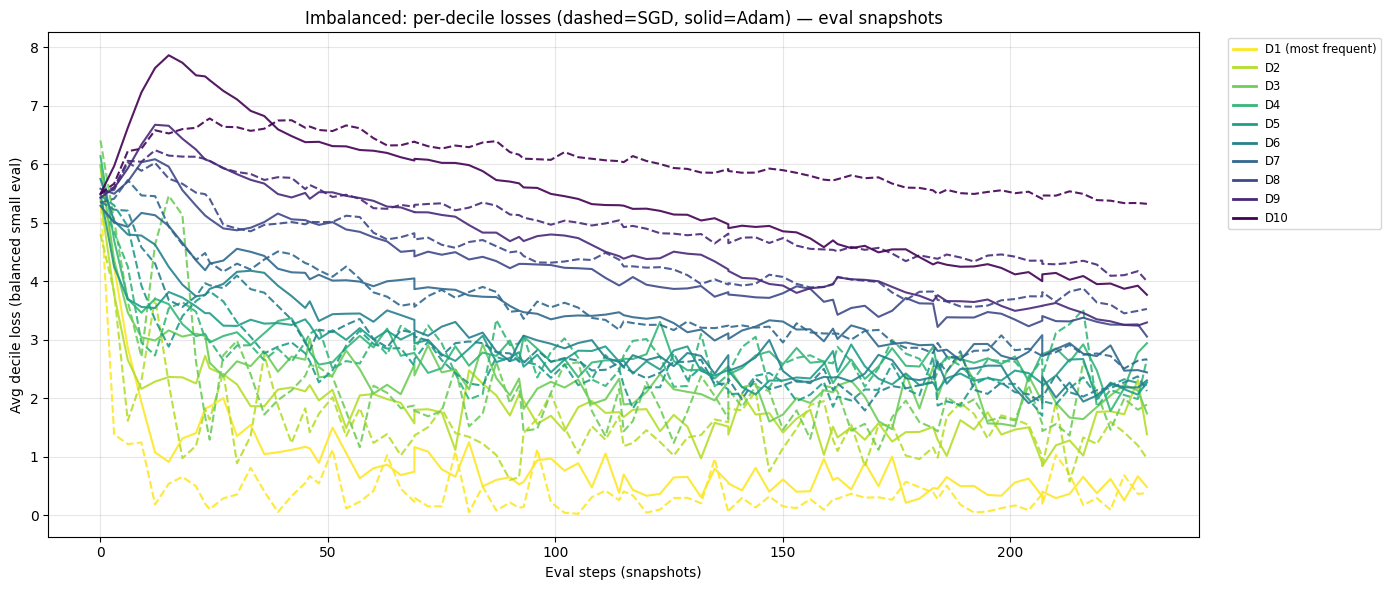

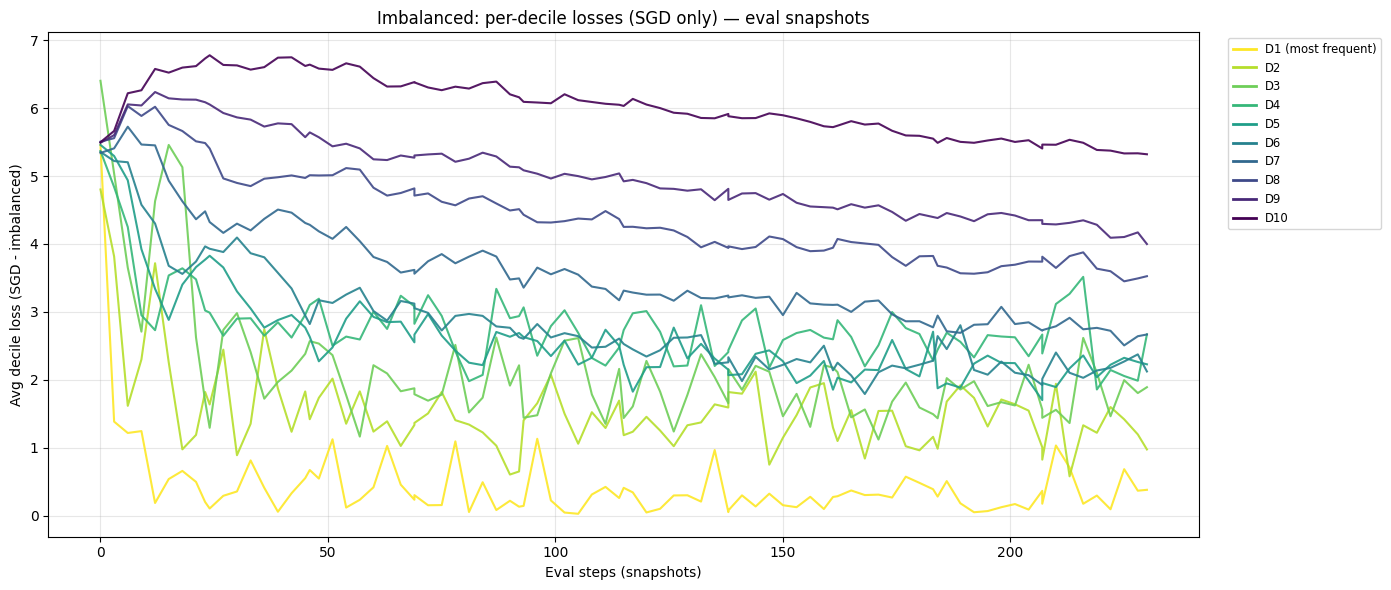

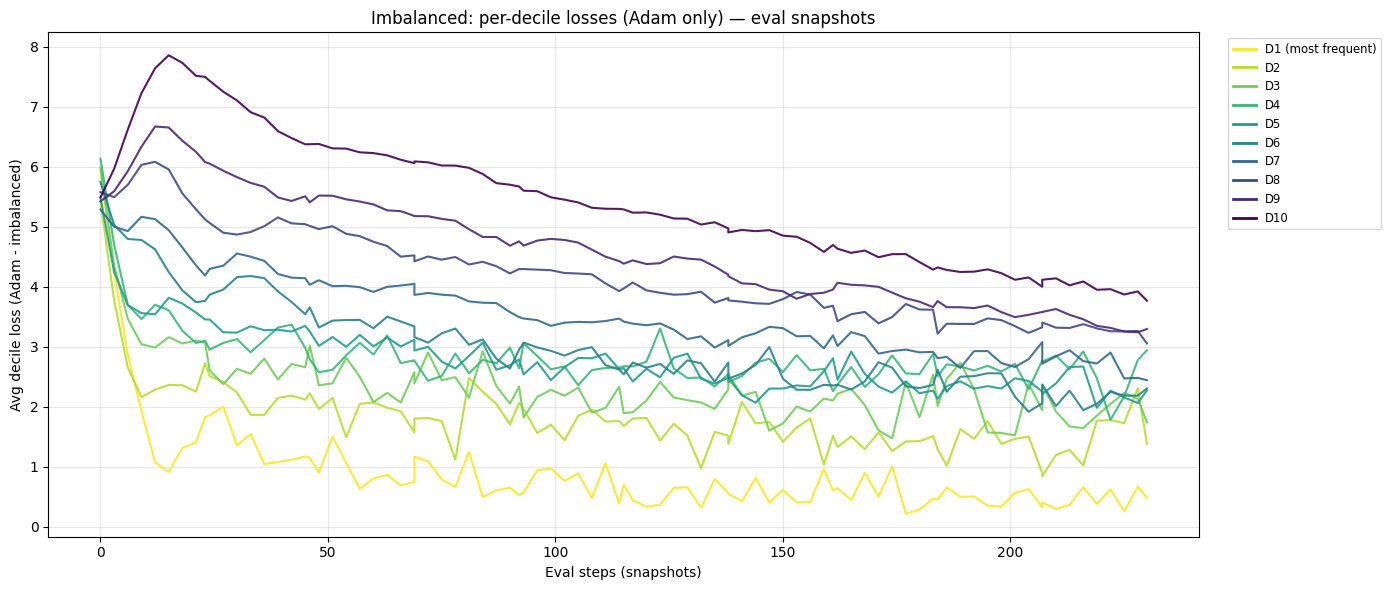

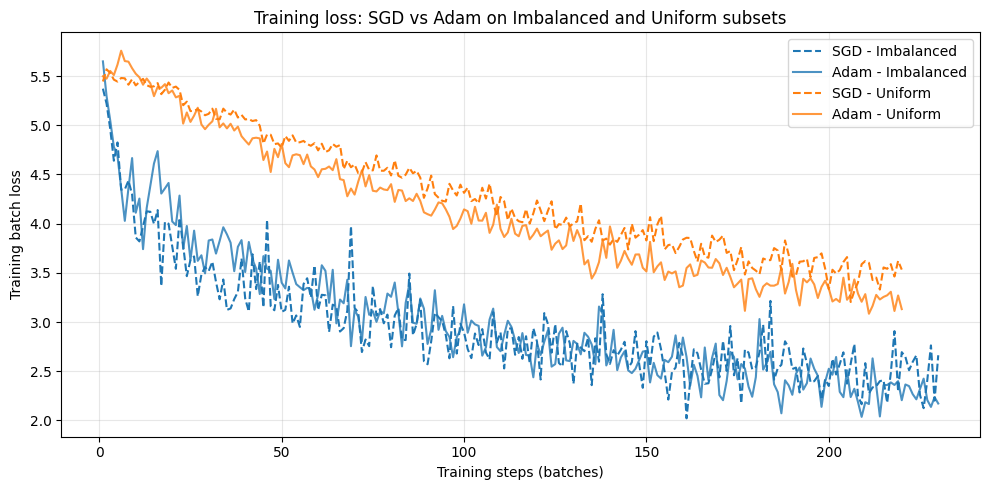

✅ Done — plots generated from saved CSVs (aligned to eval/train steps).


In [ ]:
# Paste & run this in Colab to load saved files and replot results (updated for train/eval separation).
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Where results were saved
RESULTS_DIRS = ['experiment_results', '.']  # check these paths

# expected file patterns (CSV names saved by your pipeline)
decile_files_expected = {
    'sgd_imbalanced': 'sgd_imbalanced_deciles.csv',
    'adam_imbalanced': 'adam_imbalanced_deciles.csv'
}
overall_files_expected = {
    'sgd_imbalanced': 'sgd_imbalanced_overall.csv',
    'adam_imbalanced': 'adam_imbalanced_overall.csv',
    'sgd_uniform': 'sgd_uniform_overall.csv',
    'adam_uniform': 'adam_uniform_overall.csv'
}

# helper to find file in likely directories
def find_file(fname):
    for d in RESULTS_DIRS:
        p = os.path.join(d, fname)
        if os.path.exists(p):
            return p
    return None

# If files missing, prompt upload
missing = []
for k,f in list(decile_files_expected.items()) + list(overall_files_expected.items()):
    if find_file((f if isinstance(f,str) else f[1])) is None:
        missing.append(f if isinstance(f,str) else f[1])

if len(missing) > 0:
    print("Some result files not found locally. You can upload them now (select the CSV files you saved).")
    from google.colab import files
    uploaded = files.upload()  # user selects files
    # save them to working dir
    for name, data in uploaded.items():
        with open(name, 'wb') as fh:
            fh.write(data)
    print("Uploaded files saved to working dir.")

# Now load decile CSVs (imbalanced sgd/adam)
def load_decile_csv(opt_dataset):
    fname = decile_files_expected[opt_dataset]
    p = find_file(fname) or fname
    if not os.path.exists(p):
        raise FileNotFoundError(f"Decile CSV not found: {fname}")
    df = pd.read_csv(p)
    eval_steps = df['Step'].to_numpy()
    deciles = df.drop(columns=['Step']).to_numpy().T  # shape (num_deciles, T_eval)
    colnames = df.columns[1:].tolist()
    return eval_steps, deciles, colnames

def load_overall_csv(opt_dataset):
    fname = overall_files_expected[opt_dataset]
    p = find_file(fname) or fname
    if not os.path.exists(p):
        raise FileNotFoundError(f"Overall CSV not found: {fname}")
    df = pd.read_csv(p)
    train_steps = df['Step'].to_numpy()
    train_losses = df['Overall_Loss'].to_numpy()
    return train_steps, train_losses

# load files
eval_sgd_steps, decile_sgd_imb, decile_names = load_decile_csv('sgd_imbalanced')
eval_adam_steps, decile_adam_imb, _ = load_decile_csv('adam_imbalanced')

train_sgd_steps, sgd_train_losses = load_overall_csv('sgd_imbalanced')
train_adam_steps, adam_train_losses = load_overall_csv('adam_imbalanced')
train_sgd_uni_steps, sgd_uni_train_losses = load_overall_csv('sgd_uniform')
train_adam_uni_steps, adam_uni_train_losses = load_overall_csv('adam_uniform')

# Basic sanity
num_deciles = decile_sgd_imb.shape[0]
print(f"Loaded decile arrays shape: {decile_sgd_imb.shape}, {decile_adam_imb.shape}")
print(f"Train losses lengths: {len(sgd_train_losses)}, {len(adam_train_losses)}")

# assume decile columns are ordered most -> least frequent (Decile_1 = most)
most_freq_decile = 0

# colormap (most frequent darker)
cmap = plt.get_cmap('viridis_r', num_deciles)

# ---------- Plot 1: per-decile losses (SGD vs Adam, same plot) ----------
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    y_sgd = np.ma.masked_invalid(decile_sgd_imb[d])
    y_adam = np.ma.masked_invalid(decile_adam_imb[d])
    plt.plot(eval_sgd_steps, y_sgd, '--', color=color, alpha=0.9)   # use eval steps for deciles
    plt.plot(eval_adam_steps, y_adam, '-', color=color, alpha=0.9)

plt.xlabel('Eval steps (snapshots)')
plt.ylabel('Avg decile loss (balanced small eval)')
plt.title('Imbalanced: per-decile losses (dashed=SGD, solid=Adam) — eval snapshots')
plt.grid(True, alpha=0.3)

# legend showing decile colors and mark most frequent
legend_elements = []
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    lab = f'D{d+1}'
    if d == most_freq_decile:
        lab += ' (most frequent)'
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=lab))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# ---------- Plot 2: per-decile losses (SGD only) ----------
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    y_sgd = np.ma.masked_invalid(decile_sgd_imb[d])
    plt.plot(eval_sgd_steps, y_sgd, '-', color=color, alpha=0.9)

plt.xlabel('Eval steps (snapshots)')
plt.ylabel('Avg decile loss (SGD - imbalanced)')
plt.title('Imbalanced: per-decile losses (SGD only) — eval snapshots')
plt.grid(True, alpha=0.3)
legend_elements = []
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    lab = f'D{d+1}'
    if d == most_freq_decile:
        lab += ' (most frequent)'
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=lab))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# ---------- Plot 3: per-decile losses (Adam only) ----------
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    y_adam = np.ma.masked_invalid(decile_adam_imb[d])
    plt.plot(eval_adam_steps, y_adam, '-', color=color, alpha=0.9)

plt.xlabel('Eval steps (snapshots)')
plt.ylabel('Avg decile loss (Adam - imbalanced)')
plt.title('Imbalanced: per-decile losses (Adam only) — eval snapshots')
plt.grid(True, alpha=0.3)
legend_elements = []
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    lab = f'D{d+1}'
    if d == most_freq_decile:
        lab += ' (most frequent)'
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=lab))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# ---------- Plot 4: overall training loss comparison (train steps) ----------
plt.figure(figsize=(10,5))
plt.plot(train_sgd_steps, sgd_train_losses, '--', label='SGD - Imbalanced', color='tab:blue')
plt.plot(train_adam_steps, adam_train_losses, '-', label='Adam - Imbalanced', color='tab:blue', alpha=0.8)
plt.plot(train_sgd_uni_steps, sgd_uni_train_losses, '--', label='SGD - Uniform', color='tab:orange')
plt.plot(train_adam_uni_steps, adam_uni_train_losses, '-', label='Adam - Uniform', color='tab:orange', alpha=0.8)
plt.xlabel('Training steps (batches)')
plt.ylabel('Training batch loss')
plt.title('Training loss: SGD vs Adam on Imbalanced and Uniform subsets')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Done — plots generated from saved CSVs (aligned to eval/train steps).")


Device: cuda
Class counts summary: C=1000, total_train=5682, n1=800, alpha=1.0
First 10 class sizes: [800 400 266 200 160 133 114 100  88  80]
Train shape: (5682, 6400) (5682,)
Val balanced shape: (8000, 6400) (8000,)
decile sample counts: [800 400 626 515 532 555 558 562 566 568] sum: 5682
[Init] sgd: val_loss=7.0086


sgd EP1:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 2: val_loss=36.9121
  Eval @ step 4: val_loss=43.3513
  Eval @ step 6: val_loss=55.9835
  Eval @ step 8: val_loss=61.8314
  Eval @ step 10: val_loss=65.8656
  Eval @ step 12: val_loss=147.6078
[Epoch 1] sgd: val_loss=147.6078


sgd EP2:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 14: val_loss=103.8930
  Eval @ step 16: val_loss=104.5376
  Eval @ step 18: val_loss=101.6271
  Eval @ step 20: val_loss=103.2243
  Eval @ step 22: val_loss=121.5025
  Eval @ step 24: val_loss=120.1295
[Epoch 2] sgd: val_loss=120.1295


sgd EP3:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 26: val_loss=125.0290
  Eval @ step 28: val_loss=158.7671
  Eval @ step 30: val_loss=139.8031
  Eval @ step 32: val_loss=198.9733
  Eval @ step 34: val_loss=166.9042
  Eval @ step 36: val_loss=145.5112
[Epoch 3] sgd: val_loss=145.5112


sgd EP4:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 38: val_loss=139.5191
  Eval @ step 40: val_loss=136.4180
  Eval @ step 42: val_loss=264.5614
  Eval @ step 44: val_loss=149.0363
  Eval @ step 46: val_loss=146.3206
  Eval @ step 48: val_loss=155.5587
[Epoch 4] sgd: val_loss=155.5587


sgd EP5:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 50: val_loss=153.8325
  Eval @ step 52: val_loss=155.0944
  Eval @ step 54: val_loss=154.6654
  Eval @ step 56: val_loss=158.5511
  Eval @ step 58: val_loss=149.5750
  Eval @ step 60: val_loss=142.2977
[Epoch 5] sgd: val_loss=142.2977


sgd EP6:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 62: val_loss=138.3034
  Eval @ step 64: val_loss=152.3595
  Eval @ step 66: val_loss=136.5809
  Eval @ step 68: val_loss=178.2232
  Eval @ step 70: val_loss=131.8007
  Eval @ step 72: val_loss=187.9018
[Epoch 6] sgd: val_loss=187.9018


sgd EP7:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 74: val_loss=161.6093
  Eval @ step 76: val_loss=159.9247
  Eval @ step 78: val_loss=168.6224
  Eval @ step 80: val_loss=156.3154
  Eval @ step 82: val_loss=169.1129
  Eval @ step 84: val_loss=156.7530
[Epoch 7] sgd: val_loss=156.7530


sgd EP8:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 86: val_loss=149.2450
  Eval @ step 88: val_loss=147.2018
  Eval @ step 90: val_loss=154.3105
  Eval @ step 92: val_loss=147.7778
  Eval @ step 94: val_loss=141.0255
  Eval @ step 96: val_loss=204.9650
[Epoch 8] sgd: val_loss=204.9650


sgd EP9:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 98: val_loss=191.1519
  Eval @ step 100: val_loss=146.2337
  Eval @ step 102: val_loss=143.5008
  Eval @ step 104: val_loss=138.0387
  Eval @ step 106: val_loss=180.5620
  Eval @ step 108: val_loss=191.4076
[Epoch 9] sgd: val_loss=191.4076


sgd EP10:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 110: val_loss=134.8251
  Eval @ step 112: val_loss=133.4182
  Eval @ step 114: val_loss=132.3911
  Eval @ step 116: val_loss=172.8672
  Eval @ step 118: val_loss=151.1309
  Eval @ step 120: val_loss=129.3402
[Epoch 10] sgd: val_loss=129.3402


sgd EP11:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 122: val_loss=167.8061
  Eval @ step 124: val_loss=121.7588
  Eval @ step 126: val_loss=116.4550
  Eval @ step 128: val_loss=149.0325
  Eval @ step 130: val_loss=112.5910
  Eval @ step 132: val_loss=107.6016
[Epoch 11] sgd: val_loss=107.6016


sgd EP12:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 134: val_loss=120.4773
  Eval @ step 136: val_loss=155.7600
  Eval @ step 138: val_loss=147.2133
  Eval @ step 140: val_loss=110.1864
  Eval @ step 142: val_loss=104.8369
  Eval @ step 144: val_loss=102.3525
[Epoch 12] sgd: val_loss=102.3525


sgd EP13:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 146: val_loss=96.9076
  Eval @ step 148: val_loss=91.4483
  Eval @ step 150: val_loss=141.1807
  Eval @ step 152: val_loss=105.0232
  Eval @ step 154: val_loss=98.9900
  Eval @ step 156: val_loss=147.7598
[Epoch 13] sgd: val_loss=147.7598


sgd EP14:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 158: val_loss=116.4017
  Eval @ step 160: val_loss=100.6533
  Eval @ step 162: val_loss=95.2868
  Eval @ step 164: val_loss=90.3443
  Eval @ step 166: val_loss=111.9109
  Eval @ step 168: val_loss=90.5487
[Epoch 14] sgd: val_loss=90.5487


sgd EP15:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 170: val_loss=90.8985
  Eval @ step 172: val_loss=148.6166
  Eval @ step 174: val_loss=180.1595
  Eval @ step 176: val_loss=91.8450
  Eval @ step 178: val_loss=112.5652
  Eval @ step 180: val_loss=142.5961
[Epoch 15] sgd: val_loss=142.5961


sgd EP16:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 182: val_loss=94.2289
  Eval @ step 184: val_loss=127.0096
  Eval @ step 186: val_loss=92.9701
  Eval @ step 188: val_loss=91.1756
  Eval @ step 190: val_loss=87.2821
  Eval @ step 192: val_loss=84.2139
[Epoch 16] sgd: val_loss=84.2139


sgd EP17:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 194: val_loss=120.5327
  Eval @ step 196: val_loss=125.3001
  Eval @ step 198: val_loss=114.9539
  Eval @ step 200: val_loss=99.9538
  Eval @ step 202: val_loss=98.8591
  Eval @ step 204: val_loss=86.0207
[Epoch 17] sgd: val_loss=86.0207


sgd EP18:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 206: val_loss=83.1498
  Eval @ step 208: val_loss=106.5291
  Eval @ step 210: val_loss=80.5185
  Eval @ step 212: val_loss=98.8716
  Eval @ step 214: val_loss=104.5019
  Eval @ step 216: val_loss=89.4276
[Epoch 18] sgd: val_loss=89.4276


sgd EP19:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 218: val_loss=74.5071
  Eval @ step 220: val_loss=91.1621
  Eval @ step 222: val_loss=71.0929
  Eval @ step 224: val_loss=73.4766
  Eval @ step 226: val_loss=67.7476
  Eval @ step 228: val_loss=90.6907
[Epoch 19] sgd: val_loss=90.6907


sgd EP20:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 230: val_loss=65.5633
  Eval @ step 232: val_loss=62.9731
  Eval @ step 234: val_loss=62.2168
  Eval @ step 236: val_loss=85.2957
  Eval @ step 238: val_loss=82.7125
  Eval @ step 240: val_loss=61.2516
[Epoch 20] sgd: val_loss=61.2516
[Init] adam: val_loss=7.0147


adam EP1:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 2: val_loss=12.3473
  Eval @ step 4: val_loss=14.8003
  Eval @ step 6: val_loss=14.5333
  Eval @ step 8: val_loss=13.8826
  Eval @ step 10: val_loss=13.0948
  Eval @ step 12: val_loss=12.2706
[Epoch 1] adam: val_loss=12.2706


adam EP2:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 14: val_loss=11.5556
  Eval @ step 16: val_loss=10.6039
  Eval @ step 18: val_loss=9.9054
  Eval @ step 20: val_loss=9.2729
  Eval @ step 22: val_loss=8.7844
  Eval @ step 24: val_loss=8.7615
[Epoch 2] adam: val_loss=8.7615


adam EP3:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 26: val_loss=9.0604
  Eval @ step 28: val_loss=9.1606
  Eval @ step 30: val_loss=9.4169
  Eval @ step 32: val_loss=9.5433
  Eval @ step 34: val_loss=9.4645
  Eval @ step 36: val_loss=9.3951
[Epoch 3] adam: val_loss=9.3951


adam EP4:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 38: val_loss=9.5085
  Eval @ step 40: val_loss=9.4156
  Eval @ step 42: val_loss=9.3418
  Eval @ step 44: val_loss=9.2632
  Eval @ step 46: val_loss=9.1456
  Eval @ step 48: val_loss=9.2693
[Epoch 4] adam: val_loss=9.2693


adam EP5:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 50: val_loss=9.5642
  Eval @ step 52: val_loss=9.7195
  Eval @ step 54: val_loss=9.8829
  Eval @ step 56: val_loss=9.9581
  Eval @ step 58: val_loss=9.9517
  Eval @ step 60: val_loss=10.0168
[Epoch 5] adam: val_loss=10.0168


adam EP6:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 62: val_loss=10.1899
  Eval @ step 64: val_loss=10.2324
  Eval @ step 66: val_loss=10.3486
  Eval @ step 68: val_loss=10.3821
  Eval @ step 70: val_loss=10.3297
  Eval @ step 72: val_loss=10.4388
[Epoch 6] adam: val_loss=10.4388


adam EP7:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 74: val_loss=10.7220
  Eval @ step 76: val_loss=10.9119
  Eval @ step 78: val_loss=10.8090
  Eval @ step 80: val_loss=10.6182
  Eval @ step 82: val_loss=10.4985
  Eval @ step 84: val_loss=10.5671
[Epoch 7] adam: val_loss=10.5671


adam EP8:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 86: val_loss=10.6834
  Eval @ step 88: val_loss=10.8499
  Eval @ step 90: val_loss=10.8296
  Eval @ step 92: val_loss=10.6561
  Eval @ step 94: val_loss=10.5881
  Eval @ step 96: val_loss=10.6914
[Epoch 8] adam: val_loss=10.6914


adam EP9:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 98: val_loss=10.9413
  Eval @ step 100: val_loss=10.9203
  Eval @ step 102: val_loss=10.7538
  Eval @ step 104: val_loss=10.7167
  Eval @ step 106: val_loss=10.6922
  Eval @ step 108: val_loss=10.7282
[Epoch 9] adam: val_loss=10.7282


adam EP10:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 110: val_loss=10.9841
  Eval @ step 112: val_loss=10.9445
  Eval @ step 114: val_loss=10.7908
  Eval @ step 116: val_loss=10.7556
  Eval @ step 118: val_loss=10.8339
  Eval @ step 120: val_loss=11.0594
[Epoch 10] adam: val_loss=11.0594


adam EP11:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 122: val_loss=11.1747
  Eval @ step 124: val_loss=10.9830
  Eval @ step 126: val_loss=10.8100
  Eval @ step 128: val_loss=10.8443
  Eval @ step 130: val_loss=10.9868
  Eval @ step 132: val_loss=11.1446
[Epoch 11] adam: val_loss=11.1446


adam EP12:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 134: val_loss=11.1035
  Eval @ step 136: val_loss=11.0342
  Eval @ step 138: val_loss=11.0937
  Eval @ step 140: val_loss=11.1739
  Eval @ step 142: val_loss=11.0681
  Eval @ step 144: val_loss=11.0790
[Epoch 12] adam: val_loss=11.0790


adam EP13:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 146: val_loss=11.3535
  Eval @ step 148: val_loss=11.3070
  Eval @ step 150: val_loss=11.1834
  Eval @ step 152: val_loss=11.1459
  Eval @ step 154: val_loss=11.1637
  Eval @ step 156: val_loss=11.2738
[Epoch 13] adam: val_loss=11.2738


adam EP14:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 158: val_loss=11.3399
  Eval @ step 160: val_loss=11.2149
  Eval @ step 162: val_loss=11.1441
  Eval @ step 164: val_loss=11.1137
  Eval @ step 166: val_loss=11.2422
  Eval @ step 168: val_loss=11.2070
[Epoch 14] adam: val_loss=11.2070


adam EP15:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 170: val_loss=11.2778
  Eval @ step 172: val_loss=11.3523
  Eval @ step 174: val_loss=11.3296
  Eval @ step 176: val_loss=11.2932
  Eval @ step 178: val_loss=11.2261
  Eval @ step 180: val_loss=11.3179
[Epoch 15] adam: val_loss=11.3179


adam EP16:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 182: val_loss=11.3573
  Eval @ step 184: val_loss=11.4450
  Eval @ step 186: val_loss=11.3904
  Eval @ step 188: val_loss=11.3765
  Eval @ step 190: val_loss=11.3938
  Eval @ step 192: val_loss=11.3505
[Epoch 16] adam: val_loss=11.3505


adam EP17:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 194: val_loss=11.4478
  Eval @ step 196: val_loss=11.3470
  Eval @ step 198: val_loss=11.4650
  Eval @ step 200: val_loss=11.4632
  Eval @ step 202: val_loss=11.3642
  Eval @ step 204: val_loss=11.4148
[Epoch 17] adam: val_loss=11.4148


adam EP18:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 206: val_loss=11.5486
  Eval @ step 208: val_loss=11.4255
  Eval @ step 210: val_loss=11.4034
  Eval @ step 212: val_loss=11.3733
  Eval @ step 214: val_loss=11.4166
  Eval @ step 216: val_loss=11.5959
[Epoch 18] adam: val_loss=11.5959


adam EP19:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 218: val_loss=11.4886
  Eval @ step 220: val_loss=11.4655
  Eval @ step 222: val_loss=11.5154
  Eval @ step 224: val_loss=11.5298
  Eval @ step 226: val_loss=11.4818
  Eval @ step 228: val_loss=11.4412
[Epoch 19] adam: val_loss=11.4412


adam EP20:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 230: val_loss=11.5515
  Eval @ step 232: val_loss=11.5173
  Eval @ step 234: val_loss=11.5480
  Eval @ step 236: val_loss=11.5462
  Eval @ step 238: val_loss=11.5550
  Eval @ step 240: val_loss=11.5132
[Epoch 20] adam: val_loss=11.5132


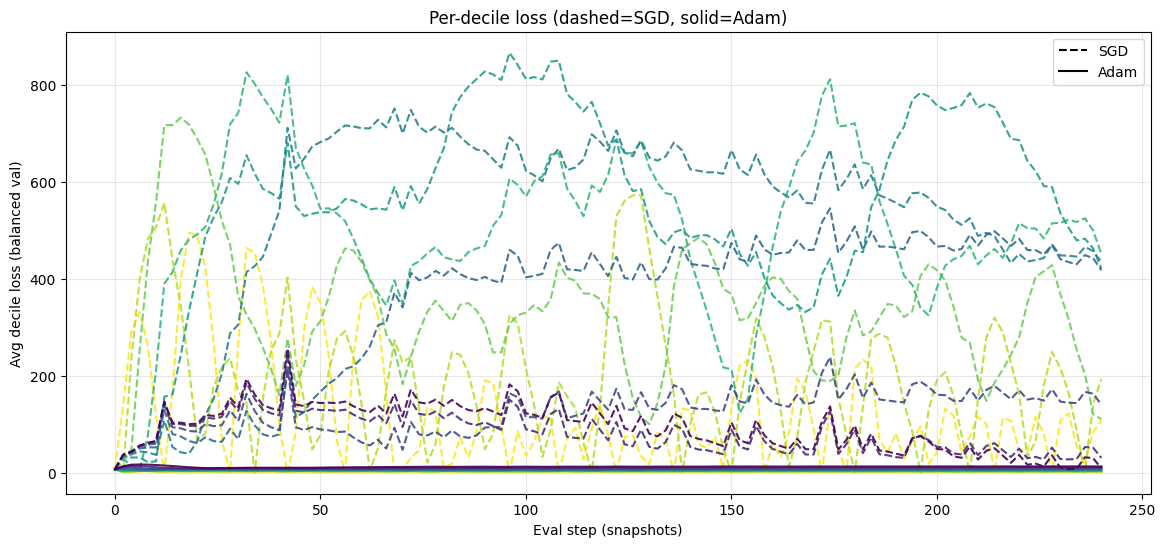

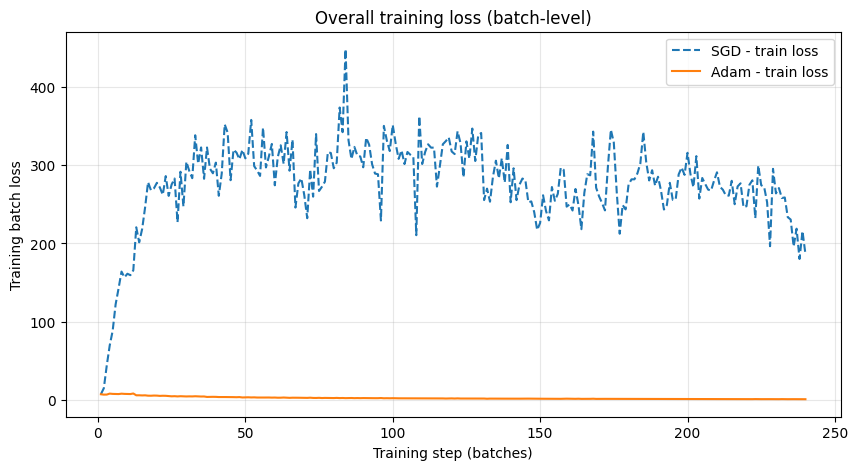

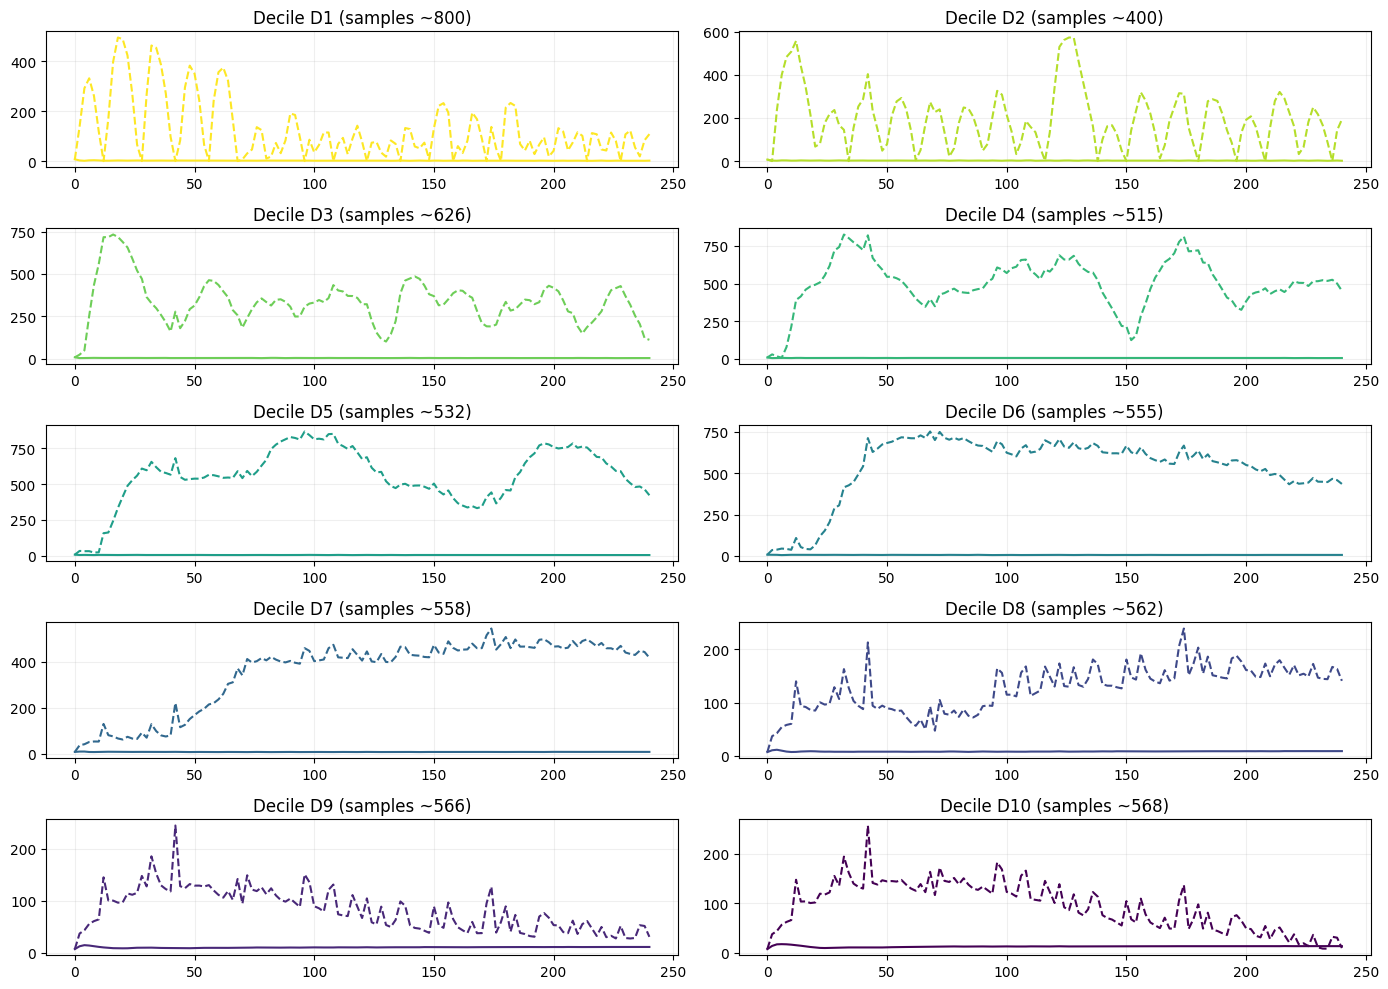

Final macro (mean over deciles) at last eval snapshot:
SGD decile means: 231.80199612893352
Adam decile means: 6.03816311993108


In [ ]:
# Paste & run in Colab (one cell)
# Synthetic softmax linear experiment: heavy-tail 1/k class sizes, compare SGD vs Adam.
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------
# Config (tweak these)
# ------------------------------
C = 1000           # number of classes
d = 6400             # input dimension
n1 = 800           # samples for class 1 (largest class). Increase for stronger head mass.
alpha = 1.0        # exponent in n_k ~ n1 / k^alpha  (alpha=1 => 1/k)
k_val = 8          # number of balanced validation samples per class
batch_size = 512
epochs = 20
evals_per_epoch = 6
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Build class sizes n_k ∝ n1 / k^alpha
# ------------------------------
ks = np.arange(1, C+1)
desired = (n1 / (ks**alpha)).astype(int)
desired[desired == 0] = 1
# total training samples
total_train = desired.sum()
print(f"Class counts summary: C={C}, total_train={total_train}, n1={n1}, alpha={alpha}")
print("First 10 class sizes:", desired[:10])

# ------------------------------
# Create synthetic inputs and labels
# Inputs ~ Uniform(0,1)^d
# We'll create a train set and a balanced val set (k_val per class)
# ------------------------------
X_list = []
y_list = []
X_val_list = []
y_val_list = []

for k, nk in enumerate(desired, start=1):
    # training samples
    Xk = np.random.rand(nk, d).astype(np.float32)
    yk = np.full(nk, k-1, dtype=np.int64)
    X_list.append(Xk); y_list.append(yk)
    # validation balanced samples (k_val per class)
    Xvk = np.random.rand(k_val, d).astype(np.float32)
    yvk = np.full(k_val, k-1, dtype=np.int64)
    X_val_list.append(Xvk); y_val_list.append(yvk)

X_train = np.vstack(X_list)
y_train = np.concatenate(y_list)
X_val_balanced = np.vstack(X_val_list)
y_val_balanced = np.concatenate(y_val_list)

print("Train shape:", X_train.shape, y_train.shape)
print("Val balanced shape:", X_val_balanced.shape, y_val_balanced.shape)

# Convert to tensors & DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_bal_ds = TensorDataset(torch.from_numpy(X_val_balanced), torch.from_numpy(y_val_balanced))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_bal_ds, batch_size=1024, shuffle=False)

# ------------------------------
# Build softmax linear model (single linear layer)
# ------------------------------
class SoftmaxLinear(nn.Module):
    def __init__(self, d, C):
        super().__init__()
        self.fc = nn.Linear(d, C)   # overparameterization achieved by C*d relative to samples
    def forward(self, x):
        return self.fc(x)

def get_model():
    m = SoftmaxLinear(d, C).to(device)
    # initialize small
    nn.init.normal_(m.fc.weight, std=0.01)
    nn.init.zeros_(m.fc.bias)
    return m

# ------------------------------
# helpers: evaluate per-class avg losses on balanced val loader
# ------------------------------
loss_fn_none = nn.CrossEntropyLoss(reduction='none')

def evaluate_per_class(model, loader):
    model.eval()
    per_class_loss = np.zeros(C, dtype=float)
    per_class_count = np.zeros(C, dtype=int)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            losses = loss_fn_none(logits, yb)  # per-sample
            total_loss += losses.sum().item()
            total_samples += yb.size(0)
            y_cpu = yb.cpu().numpy()
            losses_cpu = losses.cpu().numpy()
            for i, label in enumerate(y_cpu):
                per_class_loss[label] += float(losses_cpu[i])
                per_class_count[label] += 1
    per_class_avg = np.full(C, np.nan, dtype=float)
    mask = per_class_count > 0
    per_class_avg[mask] = per_class_loss[mask] / per_class_count[mask]
    overall_avg = total_loss / max(1, total_samples)
    return overall_avg, per_class_avg, per_class_count

# ------------------------------
# decile grouping by sample MASS (~10% of samples per decile)
# ------------------------------
class_freqs = desired.copy()
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]
total_samples = sorted_counts.sum()
cuts = [total_samples * i / 10.0 for i in range(1,10)]
cumsum = np.cumsum(sorted_counts)
cut_positions = np.searchsorted(cumsum, cuts, side='left')

decile_indices = []
prev = 0
for pos in cut_positions:
    if pos < prev:
        pos = prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])
    prev = pos+1
decile_indices.append(sorted_classes_desc[prev:])
# fix empty bins robustly (borrow from neighbors) - simplified
for i in range(len(decile_indices)):
    if len(decile_indices[i]) == 0:
        # borrow one class from neighbor if possible
        if i+1 < len(decile_indices) and len(decile_indices[i+1]) > 1:
            decile_indices[i] = np.array([decile_indices[i+1][0]])
            decile_indices[i+1] = decile_indices[i+1][1:]
        elif i-1 >= 0 and len(decile_indices[i-1]) > 1:
            decile_indices[i] = np.array([decile_indices[i-1][-1]])
            decile_indices[i-1] = decile_indices[i-1][:-1]

decile_counts = np.array([class_freqs[inds].sum() if len(inds)>0 else 0 for inds in decile_indices])
print("decile sample counts:", decile_counts, "sum:", decile_counts.sum())
num_deciles = len(decile_indices)

# ------------------------------
# runner: train model and snapshot balanced eval per-class averages
# ------------------------------
def run_single(optimizer_name='sgd', lr=None):
    model = get_model()
    if optimizer_name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=(0.1 if lr is None else lr), momentum=0.9)
    elif optimizer_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=(1e-3 if lr is None else lr))
    else:
        raise ValueError
    T = len(train_loader)
    eval_interval = max(1, T // evals_per_epoch)

    train_steps = []
    train_losses = []
    eval_steps = []
    per_class_hist = []
    global_step = 0

    # initial snapshot before training
    ov, pc_avg, pc_cnt = evaluate_per_class(model, val_loader)
    eval_steps.append(0)
    per_class_hist.append(pc_avg.copy())
    print(f"[Init] {optimizer_name}: val_loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        pbar = tqdm(train_loader, desc=f"{optimizer_name} EP{ep+1}", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = nn.functional.cross_entropy(logits, yb)
            loss.backward()
            opt.step()

            global_step += 1
            train_steps.append(global_step)
            train_losses.append(loss.item())

            if global_step % eval_interval == 0:
                model.eval()
                ov, pc_avg, pc_cnt = evaluate_per_class(model, val_loader)
                eval_steps.append(global_step)
                per_class_hist.append(pc_avg.copy())
                print(f"  Eval @ step {global_step}: val_loss={ov:.4f}")
                model.train()
        # epoch-end eval snapshot
        model.eval()
        ov, pc_avg, pc_cnt = evaluate_per_class(model, val_loader)
        eval_steps.append(global_step)
        per_class_hist.append(pc_avg.copy())
        print(f"[Epoch {ep+1}] {optimizer_name}: val_loss={ov:.4f}")
        model.train()

    return {
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        'eval_steps': np.array(eval_steps),
        'per_class_history': np.stack(per_class_hist)  # shape T_eval x C
    }

# ------------------------------
# Run SGD and Adam
# ------------------------------
res_sgd = run_single('sgd', lr=0.1)
res_adam = run_single('adam', lr=1e-3)

# ------------------------------
# compute decile histories (use nanmean to ignore missing classes if any)
# ------------------------------
def per_decile_history_from_res(res):
    per_class_hist = res['per_class_history']  # shape (T_eval, C)
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan)
    for d, inds in enumerate(decile_indices):
        if len(inds) == 0:
            continue
        decile_hist[d, :] = np.nanmean(per_class_hist[:, inds], axis=1)
    return decile_hist

decile_sgd = per_decile_history_from_res(res_sgd)
decile_adam = per_decile_history_from_res(res_adam)

# ------------------------------
# PLOT: decile losses (eval snapshots) and train losses (batch granularity)
# ------------------------------
cmap = plt.get_cmap('viridis_r', num_deciles)

# Deciles combined
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles-1))
    y_sgd = np.ma.masked_invalid(decile_sgd[d])
    y_ad = np.ma.masked_invalid(decile_adam[d])
    plt.plot(res_sgd['eval_steps'], y_sgd, '--', color=color, alpha=0.9)
    plt.plot(res_adam['eval_steps'], y_ad, '-', color=color, alpha=0.9)
plt.xlabel('Eval step (snapshots)')
plt.ylabel('Avg decile loss (balanced val)')
plt.title('Per-decile loss (dashed=SGD, solid=Adam)')
legend_elements = [Line2D([0],[0], color='k', ls='--', label='SGD'), Line2D([0],[0], color='k', ls='-', label='Adam')]
plt.legend(handles=legend_elements, loc='upper right')
plt.grid(alpha=0.3)
plt.show()

# Overall training loss (batch resolution)
plt.figure(figsize=(10,5))
# downsample if too many points for plotting
def downsample(x, y, max_points=2000):
    if len(x) <= max_points:
        return x, y
    idxs = np.linspace(0, len(x)-1, max_points, dtype=int)
    return np.array(x)[idxs], np.array(y)[idxs]

xs_s, ys_s = downsample(res_sgd['train_steps'], res_sgd['train_losses'])
xa_a, ya_a = downsample(res_adam['train_steps'], res_adam['train_losses'])
plt.plot(xs_s, ys_s, '--', label='SGD - train loss')
plt.plot(xa_a, ya_a, '-', label='Adam - train loss')
plt.xlabel('Training step (batches)')
plt.ylabel('Training batch loss')
plt.title('Overall training loss (batch-level)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Decile-by-decile small figure for clarity (optional)
plt.figure(figsize=(14,10))
for d in range(num_deciles):
    plt.subplot(5,2,d+1)
    color = cmap(d / max(1, num_deciles-1))
    y_sgd = np.ma.masked_invalid(decile_sgd[d])
    y_ad = np.ma.masked_invalid(decile_adam[d])
    plt.plot(res_sgd['eval_steps'], y_sgd, '--', color=color)
    plt.plot(res_adam['eval_steps'], y_ad, '-', color=color)
    plt.title(f"Decile D{d+1} (samples ~{int(decile_counts[d])})")
    plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Print a short summary of results
print("Final macro (mean over deciles) at last eval snapshot:")
last_idx = -1
print("SGD decile means:", np.nanmean(decile_sgd[:, last_idx]))
print("Adam decile means:", np.nanmean(decile_adam[:, last_idx]))


In [1]:
# Paste & run in Colab (one cell)
# Synthetic softmax linear experiment: heavy-tail 1/k class sizes, compare SGD vs Adam.
# All evaluations are performed on the TRAINING data (no separate validation set created).
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------
# Config (tweak these)
# ------------------------------
C = 200           # number of classes
d = 2000            # input dimension
n1 = 800           # samples for class 1 (largest class)
alpha = 1.0        # exponent in n_k ~ n1 / k^alpha
batch_size = 512
epochs = 20
evals_per_epoch = 6
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Build class sizes n_k ∝ n1 / k^alpha
# ------------------------------
ks = np.arange(1, C+1)
desired = (n1 / (ks**alpha)).astype(int)
desired[desired == 0] = 1
total_train = desired.sum()
print(f"Class counts summary: C={C}, total_train={total_train}, n1={n1}, alpha={alpha}")
print("First 10 class sizes:", desired[:10])

# ------------------------------
# Create synthetic inputs and labels (TRAIN ONLY)
# Inputs ~ Uniform(0,1)^d
# ------------------------------
X_list = []
y_list = []

for k, nk in enumerate(desired, start=1):
    Xk = np.random.rand(nk, d).astype(np.float32)
    yk = np.full(nk, k-1, dtype=np.int64)
    X_list.append(Xk); y_list.append(yk)

X_train = np.vstack(X_list)
y_train = np.concatenate(y_list)

print("Train shape:", X_train.shape, y_train.shape)

# Convert to tensors & DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

# DataLoader used for training (shuffled)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
# DataLoader used for evaluation on training set (no shuffle)
train_eval_loader = DataLoader(train_ds, batch_size=1024, shuffle=False, num_workers=2)

# ------------------------------
# Build softmax linear model (single linear layer)
# ------------------------------
class SoftmaxLinear(nn.Module):
    def __init__(self, d, C):
        super().__init__()
        self.fc = nn.Linear(d, C)
    def forward(self, x):
        return self.fc(x)

def get_model():
    m = SoftmaxLinear(d, C).to(device)
    nn.init.normal_(m.fc.weight, std=0.01)
    nn.init.zeros_(m.fc.bias)
    return m

# ------------------------------
# helpers: evaluate per-class avg losses on the TRAINING data (no validation)
# ------------------------------
loss_fn_none = nn.CrossEntropyLoss(reduction='none')

def evaluate_per_class_on_train(model, loader):
    """
    Compute per-class average loss and overall average loss on the provided loader
    (which here will be a DataLoader over the training data).
    """
    model.eval()
    per_class_loss = np.zeros(C, dtype=float)
    per_class_count = np.zeros(C, dtype=int)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            losses = loss_fn_none(logits, yb)  # per-sample
            total_loss += losses.sum().item()
            total_samples += yb.size(0)
            y_cpu = yb.cpu().numpy()
            losses_cpu = losses.cpu().numpy()
            for i, label in enumerate(y_cpu):
                per_class_loss[label] += float(losses_cpu[i])
                per_class_count[label] += 1
    per_class_avg = np.full(C, np.nan, dtype=float)
    mask = per_class_count > 0
    per_class_avg[mask] = per_class_loss[mask] / per_class_count[mask]
    overall_avg = total_loss / max(1, total_samples)
    return overall_avg, per_class_avg, per_class_count

# ------------------------------
# decile grouping by sample MASS (~10% of samples per decile)
# ------------------------------
class_freqs = desired.copy()
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]
total_samples = sorted_counts.sum()
cuts = [total_samples * i / 10.0 for i in range(1,10)]
cumsum = np.cumsum(sorted_counts)
cut_positions = np.searchsorted(cumsum, cuts, side='left')

decile_indices = []
prev = 0
for pos in cut_positions:
    if pos < prev:
        pos = prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])
    prev = pos+1
decile_indices.append(sorted_classes_desc[prev:])
# fix empty bins robustly (borrow from neighbors) - simplified
for i in range(len(decile_indices)):
    if len(decile_indices[i]) == 0:
        if i+1 < len(decile_indices) and len(decile_indices[i+1]) > 1:
            decile_indices[i] = np.array([decile_indices[i+1][0]])
            decile_indices[i+1] = decile_indices[i+1][1:]
        elif i-1 >= 0 and len(decile_indices[i-1]) > 1:
            decile_indices[i] = np.array([decile_indices[i-1][-1]])
            decile_indices[i-1] = decile_indices[i-1][:-1]

decile_counts = np.array([class_freqs[inds].sum() if len(inds)>0 else 0 for inds in decile_indices])
print("decile sample counts:", decile_counts, "sum:", decile_counts.sum())
num_deciles = len(decile_indices)

# ------------------------------
# runner: train model and snapshot per-class averages computed on training data
# ------------------------------
def run_single(optimizer_name='sgd', lr=None):
    model = get_model()
    if optimizer_name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=(0.1 if lr is None else lr), momentum=0.9)
    elif optimizer_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=(1e-3 if lr is None else lr))
    else:
        raise ValueError
    T = len(train_loader)
    eval_interval = max(1, T // evals_per_epoch)

    train_steps = []
    train_losses = []
    eval_steps = []
    per_class_hist = []
    global_step = 0

    # initial snapshot before training (on training data)
    ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
    eval_steps.append(0)
    per_class_hist.append(pc_avg.copy())
    print(f"[Init] {optimizer_name}: train_loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        pbar = tqdm(train_loader, desc=f"{optimizer_name} EP{ep+1}", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = nn.functional.cross_entropy(logits, yb)
            loss.backward()
            opt.step()

            global_step += 1
            train_steps.append(global_step)
            train_losses.append(loss.item())

            if global_step % eval_interval == 0:
                model.eval()
                ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
                eval_steps.append(global_step)
                per_class_hist.append(pc_avg.copy())
                print(f"  Eval @ step {global_step}: train_loss={ov:.4f}")
                model.train()
        # epoch-end eval snapshot (on train data)
        model.eval()
        ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
        eval_steps.append(global_step)
        per_class_hist.append(pc_avg.copy())
        print(f"[Epoch {ep+1}] {optimizer_name}: train_loss={ov:.4f}")
        model.train()

    return {
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        'eval_steps': np.array(eval_steps),
        'per_class_history': np.stack(per_class_hist)  # shape T_eval x C
    }

# ------------------------------
# Run SGD and Adam
# ------------------------------
res_sgd = run_single('sgd', lr=0.01)
res_adam = run_single('adam', lr=1e-3)

# ------------------------------
# compute decile histories (use nanmean to ignore missing classes if any)
# ------------------------------
def per_decile_history_from_res(res):
    per_class_hist = res['per_class_history']  # shape (T_eval, C)
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan)
    for d, inds in enumerate(decile_indices):
        if len(inds) == 0:
            continue
        decile_hist[d, :] = np.nanmean(per_class_hist[:, inds], axis=1)
    return decile_hist

decile_sgd = per_decile_history_from_res(res_sgd)
decile_adam = per_decile_history_from_res(res_adam)

# ------------------------------
# PLOT: decile losses (eval snapshots) and train losses (batch granularity)
# ------------------------------
cmap = plt.get_cmap('viridis_r', num_deciles)

# Deciles combined
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles-1))
    y_sgd = np.ma.masked_invalid(decile_sgd[d])
    y_ad = np.ma.masked_invalid(decile_adam[d])
    plt.plot(res_sgd['eval_steps'], y_sgd, '--', color=color, alpha=0.9)
    plt.plot(res_adam['eval_steps'], y_ad, '-', color=color, alpha=0.9)
plt.xlabel('Eval step (snapshots on training set)')
plt.ylabel('Avg decile loss (computed on training set)')
plt.title('Per-decile loss (dashed=SGD, solid=Adam) [evaluated on training data]')
legend_elements = [Line2D([0],[0], color='k', ls='--', label='SGD'), Line2D([0],[0], color='k', ls='-', label='Adam')]
plt.legend(handles=legend_elements, loc='upper right')
plt.grid(alpha=0.3)
plt.show()

# Overall training loss (batch resolution)
plt.figure(figsize=(10,5))
def downsample(x, y, max_points=2000):
    if len(x) <= max_points:
        return x, y
    idxs = np.linspace(0, len(x)-1, max_points, dtype=int)
    return np.array(x)[idxs], np.array(y)[idxs]

xs_s, ys_s = downsample(res_sgd['train_steps'], res_sgd['train_losses'])
xa_a, ya_a = downsample(res_adam['train_steps'], res_adam['train_losses'])
plt.plot(xs_s, ys_s, '--', label='SGD - train loss')
plt.plot(xa_a, ya_a, '-', label='Adam - train loss')
plt.xlabel('Training step (batches)')
plt.ylabel('Training batch loss')
plt.title('Overall training loss (batch-level)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Decile-by-decile small figure for clarity (optional)
plt.figure(figsize=(14,10))
for d in range(num_deciles):
    plt.subplot(5,2,d+1)
    color = cmap(d / max(1, num_deciles-1))
    y_sgd = np.ma.masked_invalid(decile_sgd[d])
    y_ad = np.ma.masked_invalid(decile_adam[d])
    plt.plot(res_sgd['eval_steps'], y_sgd, '--', color=color)
    plt.plot(res_adam['eval_steps'], y_ad, '-', color=color)
    plt.title(f"Decile D{d+1} (samples ~{int(decile_counts[d])})")
    plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Print a short summary of results
print("Final macro (mean over deciles) at last eval snapshot (computed on training set):")
last_idx = -1
print("SGD decile means:", np.nanmean(decile_sgd[:, last_idx]))
print("Adam decile means:", np.nanmean(decile_adam[:, last_idx]))


KeyboardInterrupt: 

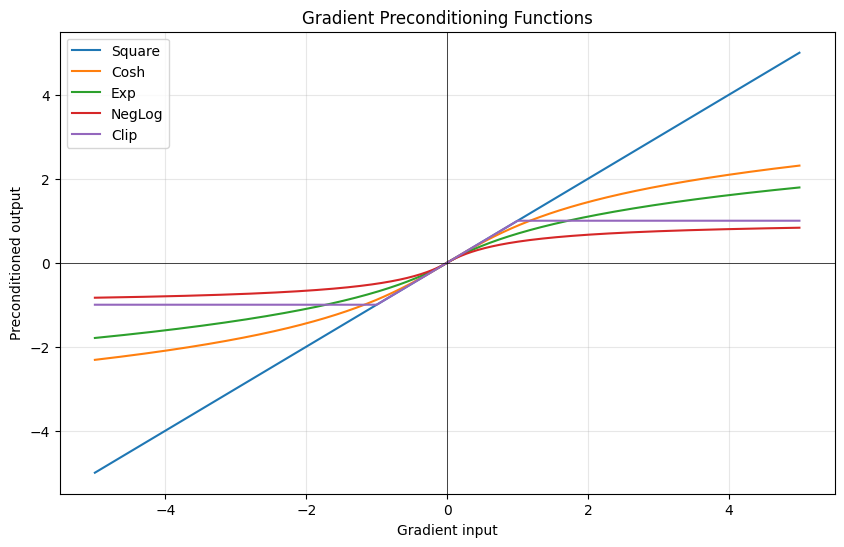

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 500)

preconditioners = {
    "Square": lambda x: x,
    "Cosh": lambda x: torch.arcsinh(x),
    "Exp": lambda x: torch.sign(x) * torch.log1p(torch.abs(x)),
    "NegLog": lambda x: x / (1 + torch.abs(x)),
    "Clip": lambda x: torch.clamp(x, -1, 1),
}

plt.figure(figsize=(10,6))
for name, f in preconditioners.items():
    plt.plot(x.numpy(), f(x).numpy(), label=name)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.xlabel("Gradient input")
plt.ylabel("Preconditioned output")
plt.title("Gradient Preconditioning Functions")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Device: cuda
Class counts summary: C=1000, total_train=5682, n1=800, alpha=1.0
First 10 class sizes: [800 400 266 200 160 133 114 100  88  80]
Train shape: (5682, 2000) (5682,)
[Init] sgd: train_loss=6.9427


sgd EP1:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.5047
  Eval @ step 4: train_loss=5.9368
  Eval @ step 6: train_loss=5.7456
  Eval @ step 8: train_loss=5.6554
  Eval @ step 10: train_loss=5.6035
  Eval @ step 12: train_loss=5.4657
[Epoch 1] sgd: train_loss=5.4657


sgd EP2:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 14: train_loss=5.4953
  Eval @ step 16: train_loss=5.3335
  Eval @ step 18: train_loss=5.2951
  Eval @ step 20: train_loss=5.1906
  Eval @ step 22: train_loss=5.2079
  Eval @ step 24: train_loss=5.1755
[Epoch 2] sgd: train_loss=5.1755


sgd EP3:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 26: train_loss=5.1272
  Eval @ step 28: train_loss=5.0950
  Eval @ step 30: train_loss=5.0994
  Eval @ step 32: train_loss=5.0606
  Eval @ step 34: train_loss=5.0578
  Eval @ step 36: train_loss=5.0441
[Epoch 3] sgd: train_loss=5.0441


sgd EP4:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 38: train_loss=5.0226
  Eval @ step 40: train_loss=5.0256
  Eval @ step 42: train_loss=5.0175
  Eval @ step 44: train_loss=4.9990
  Eval @ step 46: train_loss=4.9910
  Eval @ step 48: train_loss=5.0032
[Epoch 4] sgd: train_loss=5.0032


sgd EP5:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 50: train_loss=4.9950
  Eval @ step 52: train_loss=4.9760
  Eval @ step 54: train_loss=4.9713
  Eval @ step 56: train_loss=4.9657
  Eval @ step 58: train_loss=4.9482
  Eval @ step 60: train_loss=4.9586
[Epoch 5] sgd: train_loss=4.9586


sgd EP6:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 62: train_loss=4.9425
  Eval @ step 64: train_loss=4.9520
  Eval @ step 66: train_loss=4.9321
  Eval @ step 68: train_loss=4.9306
  Eval @ step 70: train_loss=4.9089
  Eval @ step 72: train_loss=4.9140
[Epoch 6] sgd: train_loss=4.9140


sgd EP7:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 74: train_loss=4.9034
  Eval @ step 76: train_loss=4.9020
  Eval @ step 78: train_loss=4.8973
  Eval @ step 80: train_loss=4.8855
  Eval @ step 82: train_loss=4.8768
  Eval @ step 84: train_loss=4.8811
[Epoch 7] sgd: train_loss=4.8811


sgd EP8:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=4.8741
  Eval @ step 88: train_loss=4.8708
  Eval @ step 90: train_loss=4.8566
  Eval @ step 92: train_loss=4.8555
  Eval @ step 94: train_loss=4.8483
  Eval @ step 96: train_loss=4.8465
[Epoch 8] sgd: train_loss=4.8465


sgd EP9:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 98: train_loss=4.8574
  Eval @ step 100: train_loss=4.8370
  Eval @ step 102: train_loss=4.8262
  Eval @ step 104: train_loss=4.8209
  Eval @ step 106: train_loss=4.8188
  Eval @ step 108: train_loss=4.8198
[Epoch 9] sgd: train_loss=4.8198


sgd EP10:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 110: train_loss=4.8173
  Eval @ step 112: train_loss=4.8148
  Eval @ step 114: train_loss=4.8147
  Eval @ step 116: train_loss=4.8252
  Eval @ step 118: train_loss=4.8007
  Eval @ step 120: train_loss=4.7958
[Epoch 10] sgd: train_loss=4.7958


sgd EP11:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 122: train_loss=4.7746
  Eval @ step 124: train_loss=4.7943
  Eval @ step 126: train_loss=4.7636
  Eval @ step 128: train_loss=4.7665
  Eval @ step 130: train_loss=4.7488
  Eval @ step 132: train_loss=4.7629
[Epoch 11] sgd: train_loss=4.7629


sgd EP12:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 134: train_loss=4.7371
  Eval @ step 136: train_loss=4.7424
  Eval @ step 138: train_loss=4.7384
  Eval @ step 140: train_loss=4.7268
  Eval @ step 142: train_loss=4.7144
  Eval @ step 144: train_loss=4.7302
[Epoch 12] sgd: train_loss=4.7302


sgd EP13:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 146: train_loss=4.7120
  Eval @ step 148: train_loss=4.7130
  Eval @ step 150: train_loss=4.7002
  Eval @ step 152: train_loss=4.6959
  Eval @ step 154: train_loss=4.6860
  Eval @ step 156: train_loss=4.6794
[Epoch 13] sgd: train_loss=4.6794


sgd EP14:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 158: train_loss=4.6910
  Eval @ step 160: train_loss=4.6872
  Eval @ step 162: train_loss=4.6859
  Eval @ step 164: train_loss=4.6621
  Eval @ step 166: train_loss=4.6533
  Eval @ step 168: train_loss=4.6517
[Epoch 14] sgd: train_loss=4.6517


sgd EP15:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.6614
  Eval @ step 172: train_loss=4.6475
  Eval @ step 174: train_loss=4.6375
  Eval @ step 176: train_loss=4.6321
  Eval @ step 178: train_loss=4.6287
  Eval @ step 180: train_loss=4.6253
[Epoch 15] sgd: train_loss=4.6253


sgd EP16:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 182: train_loss=4.6089
  Eval @ step 184: train_loss=4.6139
  Eval @ step 186: train_loss=4.6075
  Eval @ step 188: train_loss=4.6033
  Eval @ step 190: train_loss=4.5904
  Eval @ step 192: train_loss=4.6078
[Epoch 16] sgd: train_loss=4.6078


sgd EP17:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 194: train_loss=4.5899
  Eval @ step 196: train_loss=4.5844
  Eval @ step 198: train_loss=4.5838
  Eval @ step 200: train_loss=4.5720
  Eval @ step 202: train_loss=4.5703
  Eval @ step 204: train_loss=4.5749
[Epoch 17] sgd: train_loss=4.5749


sgd EP18:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 206: train_loss=4.5608
  Eval @ step 208: train_loss=4.5544
  Eval @ step 210: train_loss=4.5466
  Eval @ step 212: train_loss=4.5415
  Eval @ step 214: train_loss=4.5331
  Eval @ step 216: train_loss=4.5241
[Epoch 18] sgd: train_loss=4.5241


sgd EP19:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 218: train_loss=4.5220
  Eval @ step 220: train_loss=4.5197
  Eval @ step 222: train_loss=4.5113
  Eval @ step 224: train_loss=4.5092
  Eval @ step 226: train_loss=4.4941
  Eval @ step 228: train_loss=4.4930
[Epoch 19] sgd: train_loss=4.4930


sgd EP20:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 230: train_loss=4.4929
  Eval @ step 232: train_loss=4.4915
  Eval @ step 234: train_loss=4.4843
  Eval @ step 236: train_loss=4.4775
  Eval @ step 238: train_loss=4.4686
  Eval @ step 240: train_loss=4.4615
[Epoch 20] sgd: train_loss=4.4615
[Init] adam: train_loss=6.8807


adam EP1:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=5.6184
  Eval @ step 4: train_loss=5.3239
  Eval @ step 6: train_loss=5.4795
  Eval @ step 8: train_loss=5.4826
  Eval @ step 10: train_loss=5.2849
  Eval @ step 12: train_loss=5.1796
[Epoch 1] adam: train_loss=5.1796


adam EP2:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 14: train_loss=5.1061
  Eval @ step 16: train_loss=5.0324
  Eval @ step 18: train_loss=4.9485
  Eval @ step 20: train_loss=4.8702
  Eval @ step 22: train_loss=4.7908
  Eval @ step 24: train_loss=4.7355
[Epoch 2] adam: train_loss=4.7355


adam EP3:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 26: train_loss=4.7182
  Eval @ step 28: train_loss=4.6726
  Eval @ step 30: train_loss=4.6131
  Eval @ step 32: train_loss=4.5573
  Eval @ step 34: train_loss=4.4779
  Eval @ step 36: train_loss=4.3993
[Epoch 3] adam: train_loss=4.3993


adam EP4:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 38: train_loss=4.3866
  Eval @ step 40: train_loss=4.3626
  Eval @ step 42: train_loss=4.2919
  Eval @ step 44: train_loss=4.2309
  Eval @ step 46: train_loss=4.1639
  Eval @ step 48: train_loss=4.1076
[Epoch 4] adam: train_loss=4.1076


adam EP5:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 50: train_loss=4.1042
  Eval @ step 52: train_loss=4.0643
  Eval @ step 54: train_loss=3.9947
  Eval @ step 56: train_loss=3.9202
  Eval @ step 58: train_loss=3.8543
  Eval @ step 60: train_loss=3.7948
[Epoch 5] adam: train_loss=3.7948


adam EP6:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 62: train_loss=3.7764
  Eval @ step 64: train_loss=3.7574
  Eval @ step 66: train_loss=3.7047
  Eval @ step 68: train_loss=3.6254
  Eval @ step 70: train_loss=3.5598
  Eval @ step 72: train_loss=3.4988
[Epoch 6] adam: train_loss=3.4988


adam EP7:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 74: train_loss=3.4817
  Eval @ step 76: train_loss=3.4640
  Eval @ step 78: train_loss=3.4109
  Eval @ step 80: train_loss=3.3428
  Eval @ step 82: train_loss=3.2864
  Eval @ step 84: train_loss=3.2395
[Epoch 7] adam: train_loss=3.2395


adam EP8:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=3.2323
  Eval @ step 88: train_loss=3.2166
  Eval @ step 90: train_loss=3.1621
  Eval @ step 92: train_loss=3.0881
  Eval @ step 94: train_loss=3.0382
  Eval @ step 96: train_loss=3.0102
[Epoch 8] adam: train_loss=3.0102


adam EP9:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 98: train_loss=3.0121
  Eval @ step 100: train_loss=3.0003
  Eval @ step 102: train_loss=2.9659
  Eval @ step 104: train_loss=2.9173
  Eval @ step 106: train_loss=2.8616
  Eval @ step 108: train_loss=2.8181
[Epoch 9] adam: train_loss=2.8181


adam EP10:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 110: train_loss=2.8353
  Eval @ step 112: train_loss=2.8240
  Eval @ step 114: train_loss=2.7746
  Eval @ step 116: train_loss=2.7247
  Eval @ step 118: train_loss=2.6956
  Eval @ step 120: train_loss=2.6664
[Epoch 10] adam: train_loss=2.6664


adam EP11:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 122: train_loss=2.6840
  Eval @ step 124: train_loss=2.6751
  Eval @ step 126: train_loss=2.6217
  Eval @ step 128: train_loss=2.5895
  Eval @ step 130: train_loss=2.5485
  Eval @ step 132: train_loss=2.5251
[Epoch 11] adam: train_loss=2.5251


adam EP12:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 134: train_loss=2.5571
  Eval @ step 136: train_loss=2.5542
  Eval @ step 138: train_loss=2.4974
  Eval @ step 140: train_loss=2.4506
  Eval @ step 142: train_loss=2.4208
  Eval @ step 144: train_loss=2.4143
[Epoch 12] adam: train_loss=2.4143


adam EP13:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 146: train_loss=2.4502
  Eval @ step 148: train_loss=2.4521
  Eval @ step 150: train_loss=2.3935
  Eval @ step 152: train_loss=2.3430
  Eval @ step 154: train_loss=2.3136
  Eval @ step 156: train_loss=2.3136
[Epoch 13] adam: train_loss=2.3136


adam EP14:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 158: train_loss=2.3647
  Eval @ step 160: train_loss=2.3477
  Eval @ step 162: train_loss=2.2852
  Eval @ step 164: train_loss=2.2483
  Eval @ step 166: train_loss=2.2233
  Eval @ step 168: train_loss=2.2072
[Epoch 14] adam: train_loss=2.2072


adam EP15:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=2.2572
  Eval @ step 172: train_loss=2.2424
  Eval @ step 174: train_loss=2.1804
  Eval @ step 176: train_loss=2.1582
  Eval @ step 178: train_loss=2.1411
  Eval @ step 180: train_loss=2.1153
[Epoch 15] adam: train_loss=2.1153


adam EP16:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 182: train_loss=2.1503
  Eval @ step 184: train_loss=2.1564
  Eval @ step 186: train_loss=2.0899
  Eval @ step 188: train_loss=2.0609
  Eval @ step 190: train_loss=2.0446
  Eval @ step 192: train_loss=2.0182
[Epoch 16] adam: train_loss=2.0182


adam EP17:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 194: train_loss=2.0403
  Eval @ step 196: train_loss=2.0675
  Eval @ step 198: train_loss=2.0220
  Eval @ step 200: train_loss=1.9746
  Eval @ step 202: train_loss=1.9583
  Eval @ step 204: train_loss=1.9447
[Epoch 17] adam: train_loss=1.9447


adam EP18:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 206: train_loss=1.9665
  Eval @ step 208: train_loss=1.9710
  Eval @ step 210: train_loss=1.9356
  Eval @ step 212: train_loss=1.9118
  Eval @ step 214: train_loss=1.8925
  Eval @ step 216: train_loss=1.8659
[Epoch 18] adam: train_loss=1.8659


adam EP19:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 218: train_loss=1.9080
  Eval @ step 220: train_loss=1.8966
  Eval @ step 222: train_loss=1.8520
  Eval @ step 224: train_loss=1.8295
  Eval @ step 226: train_loss=1.8239
  Eval @ step 228: train_loss=1.8173
[Epoch 19] adam: train_loss=1.8173


adam EP20:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 230: train_loss=1.8450
  Eval @ step 232: train_loss=1.8401
  Eval @ step 234: train_loss=1.8044
  Eval @ step 236: train_loss=1.7591
  Eval @ step 238: train_loss=1.7558
  Eval @ step 240: train_loss=1.7482
[Epoch 20] adam: train_loss=1.7482
[Init] clip: train_loss=6.9779


clip EP1:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.6369
  Eval @ step 4: train_loss=6.3358
  Eval @ step 6: train_loss=6.0933
  Eval @ step 8: train_loss=5.9313
  Eval @ step 10: train_loss=5.8363
  Eval @ step 12: train_loss=5.7652
[Epoch 1] clip: train_loss=5.7652


clip EP2:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 14: train_loss=5.6990
  Eval @ step 16: train_loss=5.6441
  Eval @ step 18: train_loss=5.6017
  Eval @ step 20: train_loss=5.5649
  Eval @ step 22: train_loss=5.5321
  Eval @ step 24: train_loss=5.5097
[Epoch 2] clip: train_loss=5.5097


clip EP3:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 26: train_loss=5.4789
  Eval @ step 28: train_loss=5.4560
  Eval @ step 30: train_loss=5.4316
  Eval @ step 32: train_loss=5.4120
  Eval @ step 34: train_loss=5.3951
  Eval @ step 36: train_loss=5.3801
[Epoch 3] clip: train_loss=5.3801


clip EP4:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 38: train_loss=5.3642
  Eval @ step 40: train_loss=5.3518
  Eval @ step 42: train_loss=5.3386
  Eval @ step 44: train_loss=5.3257
  Eval @ step 46: train_loss=5.3153
  Eval @ step 48: train_loss=5.3077
[Epoch 4] clip: train_loss=5.3077


clip EP5:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 50: train_loss=5.2964
  Eval @ step 52: train_loss=5.2881
  Eval @ step 54: train_loss=5.2785
  Eval @ step 56: train_loss=5.2720
  Eval @ step 58: train_loss=5.2639
  Eval @ step 60: train_loss=5.2578
[Epoch 5] clip: train_loss=5.2578


clip EP6:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 62: train_loss=5.2497
  Eval @ step 64: train_loss=5.2442
  Eval @ step 66: train_loss=5.2371
  Eval @ step 68: train_loss=5.2310
  Eval @ step 70: train_loss=5.2260
  Eval @ step 72: train_loss=5.2326
[Epoch 6] clip: train_loss=5.2326


clip EP7:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 74: train_loss=5.2151
  Eval @ step 76: train_loss=5.2108
  Eval @ step 78: train_loss=5.2048
  Eval @ step 80: train_loss=5.1995
  Eval @ step 82: train_loss=5.1957
  Eval @ step 84: train_loss=5.1972
[Epoch 7] clip: train_loss=5.1972


clip EP8:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.1888
  Eval @ step 88: train_loss=5.1845
  Eval @ step 90: train_loss=5.1796
  Eval @ step 92: train_loss=5.1757
  Eval @ step 94: train_loss=5.1714
  Eval @ step 96: train_loss=5.1752
[Epoch 8] clip: train_loss=5.1752


clip EP9:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 98: train_loss=5.1682
  Eval @ step 100: train_loss=5.1631
  Eval @ step 102: train_loss=5.1583
  Eval @ step 104: train_loss=5.1555
  Eval @ step 106: train_loss=5.1516
  Eval @ step 108: train_loss=5.1731
[Epoch 9] clip: train_loss=5.1731


clip EP10:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 110: train_loss=5.1484
  Eval @ step 112: train_loss=5.1442
  Eval @ step 114: train_loss=5.1420
  Eval @ step 116: train_loss=5.1381
  Eval @ step 118: train_loss=5.1355
  Eval @ step 120: train_loss=5.1360
[Epoch 10] clip: train_loss=5.1360


clip EP11:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 122: train_loss=5.1330
  Eval @ step 124: train_loss=5.1293
  Eval @ step 126: train_loss=5.1262
  Eval @ step 128: train_loss=5.1242
  Eval @ step 130: train_loss=5.1218
  Eval @ step 132: train_loss=5.1202
[Epoch 11] clip: train_loss=5.1202


clip EP12:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 134: train_loss=5.1171
  Eval @ step 136: train_loss=5.1171
  Eval @ step 138: train_loss=5.1131
  Eval @ step 140: train_loss=5.1108
  Eval @ step 142: train_loss=5.1092
  Eval @ step 144: train_loss=5.1089
[Epoch 12] clip: train_loss=5.1089


clip EP13:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 146: train_loss=5.1073
  Eval @ step 148: train_loss=5.1034
  Eval @ step 150: train_loss=5.1012
  Eval @ step 152: train_loss=5.1002
  Eval @ step 154: train_loss=5.0979
  Eval @ step 156: train_loss=5.1016
[Epoch 13] clip: train_loss=5.1016


clip EP14:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 158: train_loss=5.0975
  Eval @ step 160: train_loss=5.0945
  Eval @ step 162: train_loss=5.0917
  Eval @ step 164: train_loss=5.0898
  Eval @ step 166: train_loss=5.0878
  Eval @ step 168: train_loss=5.0961
[Epoch 14] clip: train_loss=5.0961


clip EP15:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=5.0875
  Eval @ step 172: train_loss=5.0848
  Eval @ step 174: train_loss=5.0829
  Eval @ step 176: train_loss=5.0809
  Eval @ step 178: train_loss=5.0793
  Eval @ step 180: train_loss=5.0810
[Epoch 15] clip: train_loss=5.0810


clip EP16:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 182: train_loss=5.0782
  Eval @ step 184: train_loss=5.0749
  Eval @ step 186: train_loss=5.0733
  Eval @ step 188: train_loss=5.0717
  Eval @ step 190: train_loss=5.0702
  Eval @ step 192: train_loss=5.0705
[Epoch 16] clip: train_loss=5.0705


clip EP17:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 194: train_loss=5.0680
  Eval @ step 196: train_loss=5.0671
  Eval @ step 198: train_loss=5.0651
  Eval @ step 200: train_loss=5.0636
  Eval @ step 202: train_loss=5.0622
  Eval @ step 204: train_loss=5.0720
[Epoch 17] clip: train_loss=5.0720


clip EP18:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 206: train_loss=5.0625
  Eval @ step 208: train_loss=5.0595
  Eval @ step 210: train_loss=5.0576
  Eval @ step 212: train_loss=5.0559
  Eval @ step 214: train_loss=5.0551
  Eval @ step 216: train_loss=5.0564
[Epoch 18] clip: train_loss=5.0564


clip EP19:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 218: train_loss=5.0533
  Eval @ step 220: train_loss=5.0523
  Eval @ step 222: train_loss=5.0504
  Eval @ step 224: train_loss=5.0491
  Eval @ step 226: train_loss=5.0479
  Eval @ step 228: train_loss=5.0529
[Epoch 19] clip: train_loss=5.0529


clip EP20:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 230: train_loss=5.0469
  Eval @ step 232: train_loss=5.0477
  Eval @ step 234: train_loss=5.0451
  Eval @ step 236: train_loss=5.0432
  Eval @ step 238: train_loss=5.0425
  Eval @ step 240: train_loss=5.0493
[Epoch 20] clip: train_loss=5.0493
[Init] cosh: train_loss=6.9756


cosh EP1:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.6703
  Eval @ step 4: train_loss=6.3839
  Eval @ step 6: train_loss=6.1211
  Eval @ step 8: train_loss=5.9517
  Eval @ step 10: train_loss=5.8512
  Eval @ step 12: train_loss=5.7860
[Epoch 1] cosh: train_loss=5.7860


cosh EP2:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 14: train_loss=5.6999
  Eval @ step 16: train_loss=5.6425
  Eval @ step 18: train_loss=5.5982
  Eval @ step 20: train_loss=5.5561
  Eval @ step 22: train_loss=5.5207
  Eval @ step 24: train_loss=5.5555
[Epoch 2] cosh: train_loss=5.5555


cosh EP3:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 26: train_loss=5.4647
  Eval @ step 28: train_loss=5.4412
  Eval @ step 30: train_loss=5.4208
  Eval @ step 32: train_loss=5.4022
  Eval @ step 34: train_loss=5.3862
  Eval @ step 36: train_loss=5.3751
[Epoch 3] cosh: train_loss=5.3751


cosh EP4:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 38: train_loss=5.3589
  Eval @ step 40: train_loss=5.3458
  Eval @ step 42: train_loss=5.3325
  Eval @ step 44: train_loss=5.3225
  Eval @ step 46: train_loss=5.3106
  Eval @ step 48: train_loss=5.3051
[Epoch 4] cosh: train_loss=5.3051


cosh EP5:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 50: train_loss=5.2935
  Eval @ step 52: train_loss=5.2819
  Eval @ step 54: train_loss=5.2730
  Eval @ step 56: train_loss=5.2659
  Eval @ step 58: train_loss=5.2581
  Eval @ step 60: train_loss=5.2593
[Epoch 5] cosh: train_loss=5.2593


cosh EP6:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 62: train_loss=5.2444
  Eval @ step 64: train_loss=5.2377
  Eval @ step 66: train_loss=5.2316
  Eval @ step 68: train_loss=5.2257
  Eval @ step 70: train_loss=5.2197
  Eval @ step 72: train_loss=5.2176
[Epoch 6] cosh: train_loss=5.2176


cosh EP7:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 74: train_loss=5.2102
  Eval @ step 76: train_loss=5.2048
  Eval @ step 78: train_loss=5.1995
  Eval @ step 80: train_loss=5.1948
  Eval @ step 82: train_loss=5.1910
  Eval @ step 84: train_loss=5.1963
[Epoch 7] cosh: train_loss=5.1963


cosh EP8:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.1832
  Eval @ step 88: train_loss=5.1791
  Eval @ step 90: train_loss=5.1747
  Eval @ step 92: train_loss=5.1715
  Eval @ step 94: train_loss=5.1670
  Eval @ step 96: train_loss=5.1708
[Epoch 8] cosh: train_loss=5.1708


cosh EP9:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 98: train_loss=5.1630
  Eval @ step 100: train_loss=5.1590
  Eval @ step 102: train_loss=5.1552
  Eval @ step 104: train_loss=5.1534
  Eval @ step 106: train_loss=5.1490
  Eval @ step 108: train_loss=5.1521
[Epoch 9] cosh: train_loss=5.1521


cosh EP10:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 110: train_loss=5.1457
  Eval @ step 112: train_loss=5.1421
  Eval @ step 114: train_loss=5.1380
  Eval @ step 116: train_loss=5.1352
  Eval @ step 118: train_loss=5.1327
  Eval @ step 120: train_loss=5.1326
[Epoch 10] cosh: train_loss=5.1326


cosh EP11:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 122: train_loss=5.1303
  Eval @ step 124: train_loss=5.1255
  Eval @ step 126: train_loss=5.1230
  Eval @ step 128: train_loss=5.1205
  Eval @ step 130: train_loss=5.1189
  Eval @ step 132: train_loss=5.1258
[Epoch 11] cosh: train_loss=5.1258


cosh EP12:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 134: train_loss=5.1172
  Eval @ step 136: train_loss=5.1141
  Eval @ step 138: train_loss=5.1097
  Eval @ step 140: train_loss=5.1081
  Eval @ step 142: train_loss=5.1060
  Eval @ step 144: train_loss=5.1076
[Epoch 12] cosh: train_loss=5.1076


cosh EP13:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 146: train_loss=5.1021
  Eval @ step 148: train_loss=5.1001
  Eval @ step 150: train_loss=5.0979
  Eval @ step 152: train_loss=5.0966
  Eval @ step 154: train_loss=5.0944
  Eval @ step 156: train_loss=5.0950
[Epoch 13] cosh: train_loss=5.0950


cosh EP14:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 158: train_loss=5.0922
  Eval @ step 160: train_loss=5.0922
  Eval @ step 162: train_loss=5.0885
  Eval @ step 164: train_loss=5.0865
  Eval @ step 166: train_loss=5.0844
  Eval @ step 168: train_loss=5.1091
[Epoch 14] cosh: train_loss=5.1091


cosh EP15:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=5.0824
  Eval @ step 172: train_loss=5.0807
  Eval @ step 174: train_loss=5.0786
  Eval @ step 176: train_loss=5.0777
  Eval @ step 178: train_loss=5.0759
  Eval @ step 180: train_loss=5.0776
[Epoch 15] cosh: train_loss=5.0776


cosh EP16:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 182: train_loss=5.0762
  Eval @ step 184: train_loss=5.0721
  Eval @ step 186: train_loss=5.0705
  Eval @ step 188: train_loss=5.0684
  Eval @ step 190: train_loss=5.0667
  Eval @ step 192: train_loss=5.0750
[Epoch 16] cosh: train_loss=5.0750


cosh EP17:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 194: train_loss=5.0665
  Eval @ step 196: train_loss=5.0637
  Eval @ step 198: train_loss=5.0625
  Eval @ step 200: train_loss=5.0603
  Eval @ step 202: train_loss=5.0590
  Eval @ step 204: train_loss=5.0627
[Epoch 17] cosh: train_loss=5.0627


cosh EP18:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 206: train_loss=5.0567
  Eval @ step 208: train_loss=5.0554
  Eval @ step 210: train_loss=5.0548
  Eval @ step 212: train_loss=5.0529
  Eval @ step 214: train_loss=5.0513
  Eval @ step 216: train_loss=5.0516
[Epoch 18] cosh: train_loss=5.0516


cosh EP19:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 218: train_loss=5.0515
  Eval @ step 220: train_loss=5.0485
  Eval @ step 222: train_loss=5.0473
  Eval @ step 224: train_loss=5.0459
  Eval @ step 226: train_loss=5.0446
  Eval @ step 228: train_loss=5.0511
[Epoch 19] cosh: train_loss=5.0511


cosh EP20:   0%|          | 0/12 [00:00<?, ?it/s]

  Eval @ step 230: train_loss=5.0438
  Eval @ step 232: train_loss=5.0421
  Eval @ step 234: train_loss=5.0414
  Eval @ step 236: train_loss=5.0399
  Eval @ step 238: train_loss=5.0394
  Eval @ step 240: train_loss=5.0453
[Epoch 20] cosh: train_loss=5.0453


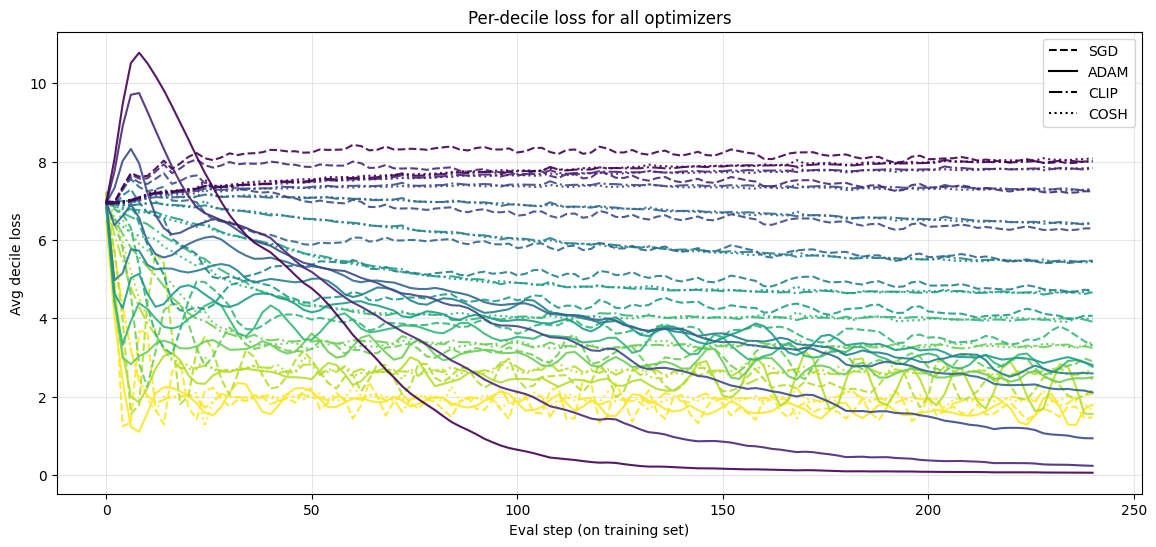

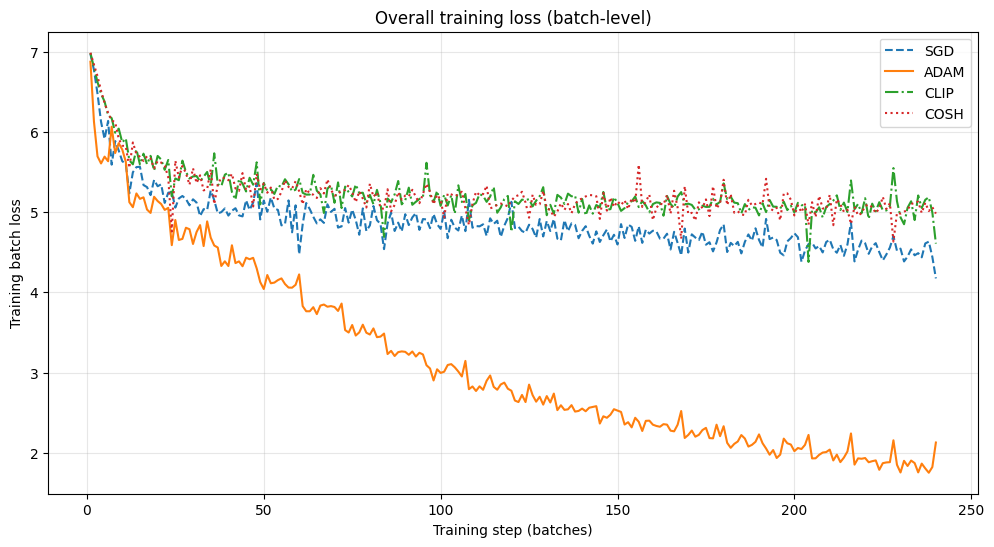

In [3]:
# Paste & run in Colab (one cell)
# Synthetic softmax linear experiment: heavy-tail 1/k class sizes, compare SGD, Adam, Clip, Cosh.
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------
# Config
# ------------------------------
C = 1000           # number of classes
d = 2000           # input dimension
n1 = 800           # samples for class 1 (largest class)
alpha = 1.0        # exponent in n_k ~ n1 / k^alpha
batch_size = 512
epochs = 20
evals_per_epoch = 6
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Build class sizes n_k ∝ n1 / k^alpha
# ------------------------------
ks = np.arange(1, C+1)
desired = (n1 / (ks**alpha)).astype(int)
desired[desired == 0] = 1
total_train = desired.sum()
print(f"Class counts summary: C={C}, total_train={total_train}, n1={n1}, alpha={alpha}")
print("First 10 class sizes:", desired[:10])

# ------------------------------
# Create synthetic inputs and labels (TRAIN ONLY)
# ------------------------------
X_list, y_list = [], []
for k, nk in enumerate(desired, start=1):
    Xk = np.random.rand(nk, d).astype(np.float32)
    yk = np.full(nk, k-1, dtype=np.int64)
    X_list.append(Xk)
    y_list.append(yk)

X_train = np.vstack(X_list)
y_train = np.concatenate(y_list)
print("Train shape:", X_train.shape, y_train.shape)

# Convert to tensors & DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
train_eval_loader = DataLoader(train_ds, batch_size=1024, shuffle=False, num_workers=2)

# ------------------------------
# Softmax linear model
# ------------------------------
class SoftmaxLinear(nn.Module):
    def __init__(self, d, C):
        super().__init__()
        self.fc = nn.Linear(d, C)
    def forward(self, x):
        return self.fc(x)

def get_model():
    m = SoftmaxLinear(d, C).to(device)
    nn.init.normal_(m.fc.weight, std=0.01)
    nn.init.zeros_(m.fc.bias)
    return m

# ------------------------------
# Preconditioners
# ------------------------------
class Preconditioner:
    def prec(self, x): return x

class Clip(Preconditioner):
    def prec(self, x): return torch.clamp(x, min=-1, max=1)

class Cosh(Preconditioner):
    def prec(self, x): return torch.arcsinh(x)

# ------------------------------
# Custom optimizer using preconditioners
# ------------------------------
from torch.optim import Optimizer
class PrecGD(Optimizer):
    def __init__(self, params, prec, lr):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        self.prec = prec
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None: continue
                p.data.add_(-lr*self.prec.prec(p.grad.data))

# ------------------------------
# Evaluation on training data
# ------------------------------
loss_fn_none = nn.CrossEntropyLoss(reduction='none')

def evaluate_per_class_on_train(model, loader):
    model.eval()
    per_class_loss = np.zeros(C, dtype=float)
    per_class_count = np.zeros(C, dtype=int)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            losses = loss_fn_none(logits, yb)
            total_loss += losses.sum().item()
            total_samples += yb.size(0)
            y_cpu = yb.cpu().numpy()
            losses_cpu = losses.cpu().numpy()
            for i, label in enumerate(y_cpu):
                per_class_loss[label] += float(losses_cpu[i])
                per_class_count[label] += 1
    per_class_avg = np.full(C, np.nan, dtype=float)
    mask = per_class_count > 0
    per_class_avg[mask] = per_class_loss[mask]/per_class_count[mask]
    overall_avg = total_loss/max(1,total_samples)
    return overall_avg, per_class_avg, per_class_count

# ------------------------------
# Decile grouping
# ------------------------------
class_freqs = desired.copy()
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]
total_samples = sorted_counts.sum()
cuts = [total_samples*i/10.0 for i in range(1,10)]
cumsum = np.cumsum(sorted_counts)
cut_positions = np.searchsorted(cumsum, cuts, side='left')

decile_indices = []
prev=0
for pos in cut_positions:
    if pos<prev: pos=prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])
    prev=pos+1
decile_indices.append(sorted_classes_desc[prev:])
# fix empty bins
for i in range(len(decile_indices)):
    if len(decile_indices[i])==0:
        if i+1<len(decile_indices) and len(decile_indices[i+1])>1:
            decile_indices[i]=np.array([decile_indices[i+1][0]])
            decile_indices[i+1]=decile_indices[i+1][1:]
        elif i-1>=0 and len(decile_indices[i-1])>1:
            decile_indices[i]=np.array([decile_indices[i-1][-1]])
            decile_indices[i-1]=decile_indices[i-1][:-1]

decile_counts = np.array([class_freqs[inds].sum() if len(inds)>0 else 0 for inds in decile_indices])
num_deciles = len(decile_indices)

# ------------------------------
# Runner
# ------------------------------
def run_single(opt_name, lr=None):
    model = get_model()
    if opt_name=='sgd':
        opt = optim.SGD(model.parameters(), lr=0.01 if lr is None else lr, momentum=0.9)
    elif opt_name=='adam':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr)
    elif opt_name=='clip':
        opt = PrecGD(model.parameters(), Clip(), lr=0.01 if lr is None else lr)
    elif opt_name=='cosh':
        opt = PrecGD(model.parameters(), Cosh(), lr=0.01 if lr is None else lr)
    else:
        raise ValueError
    T = len(train_loader)
    eval_interval = max(1, T//evals_per_epoch)

    train_steps, train_losses = [], []
    eval_steps, per_class_hist = [], []
    global_step=0

    ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
    eval_steps.append(0)
    per_class_hist.append(pc_avg.copy())
    print(f"[Init] {opt_name}: train_loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        pbar = tqdm(train_loader, desc=f"{opt_name} EP{ep+1}", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad() if hasattr(opt,'zero_grad') else None
            logits = model(xb)
            loss = nn.functional.cross_entropy(logits, yb)
            loss.backward()
            opt.step()
            global_step+=1
            train_steps.append(global_step)
            train_losses.append(loss.item())
            if global_step%eval_interval==0:
                model.eval()
                ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
                eval_steps.append(global_step)
                per_class_hist.append(pc_avg.copy())
                print(f"  Eval @ step {global_step}: train_loss={ov:.4f}")
                model.train()
        model.eval()
        ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
        eval_steps.append(global_step)
        per_class_hist.append(pc_avg.copy())
        print(f"[Epoch {ep+1}] {opt_name}: train_loss={ov:.4f}")
        model.train()

    return {
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        'eval_steps': np.array(eval_steps),
        'per_class_history': np.stack(per_class_hist)
    }

# ------------------------------
# Run all optimizers
# ------------------------------
results = {}
for opt in ['sgd','adam','clip','cosh']:
    results[opt] = run_single(opt)

# ------------------------------
# Compute decile histories
# ------------------------------
def per_decile_history_from_res(res):
    per_class_hist = res['per_class_history']
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan)
    for d, inds in enumerate(decile_indices):
        if len(inds)==0: continue
        decile_hist[d,:] = np.nanmean(per_class_hist[:,inds],axis=1)
    return decile_hist

decile_hist = {opt: per_decile_history_from_res(results[opt]) for opt in results}

# ------------------------------
# Plot per-decile loss
# ------------------------------
cmap = plt.get_cmap('viridis_r', num_deciles)
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d/(num_deciles-1))
    for opt, style in zip(['sgd','adam','clip','cosh'], ['--','-','-.',':']):
        y = np.ma.masked_invalid(decile_hist[opt][d])
        plt.plot(results[opt]['eval_steps'], y, style, color=color, alpha=0.9)
plt.xlabel('Eval step (on training set)')
plt.ylabel('Avg decile loss')
plt.title('Per-decile loss for all optimizers')
plt.grid(alpha=0.3)
legend_elements = [Line2D([0],[0], color='k', ls=s, label=o.upper()) for o,s in zip(['sgd','adam','clip','cosh'], ['--','-','-.',':'])]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

# ------------------------------
# Plot overall training loss (batch-level)
# ------------------------------
plt.figure(figsize=(12,6))
def downsample(x,y,max_points=2000):
    if len(x)<=max_points: return x,y
    idxs = np.linspace(0,len(x)-1,max_points,dtype=int)
    return np.array(x)[idxs], np.array(y)[idxs]

for opt, style, color in zip(['sgd','adam','clip','cosh'], ['--','-','-.',':'], ['tab:blue','tab:orange','tab:green','tab:red']):
    xs, ys = downsample(results[opt]['train_steps'], results[opt]['train_losses'])
    plt.plot(xs, ys, style, label=opt.upper(), color=color)

plt.xlabel('Training step (batches)')
plt.ylabel('Training batch loss')
plt.title('Overall training loss (batch-level)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()
